<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/projected_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation

%config InlineBackend.figure_format='retina'

In [2]:
def scatter_phase_function(g = 0, scatter_angle = np.pi / 2):
  mu =  np.cos(scatter_angle)
  return ((1 - g**2) / (1 + g**2  - 2 * g * mu)**(3/2) ) / 4 * np.pi

In [3]:
Deltat = 250 # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
# -- point where the plane-parallel slab of dust intersects the line of sight
# -- inclination of the plane, is perpendicular to the line of sight (I am using 89 so the tangent don't die)
alpha = 20 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
dt0 = 50 * dtoy
dz0 = 0.02 * pctoly # in ly

c = 1 # in light-year / year
ct = Deltat * dtoy
pctom = 3.086e+16 # pc to meter
n = 2.3 * (100 ** 3) #m-3
n = n * ( pctom ** 3 ) / ( pctoly ** 3 )
sigma = 5e-22 / (100 ** 2) #m2 #RR paper
sigma = ( sigma / ( (pctom ** 2) ) ) * ( pctoly ** 2 )
albedo = 0.6
Fphi = scatter_phase_function()
print(Fphi, 1/4 * np.pi)
# -- distance source - observer
dkpc = 5 #kpc
d = dkpc * 1000 * pctoly

k = sigma * albedo * Fphi
# L = 15,000 x 3.9e26 # watts = kg m ^2 / s^3
L = (15000 * 3.9e36) * ((60 * 60 * 24 * 365) ** 3) * (pctoly ** 2) / (pctom ** 2)
Ir = k * L * c / (4 * np.pi * (dkpc * 1000 * pctoly)**2)

0.7853981633974483 0.7853981633974483


In [4]:
r_le2 = 2 * z0ly * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

In [5]:
x = np.linspace(-10,10,100)
# y = np.linspace(-r_le, r_le, 100)

In [6]:
def calc_intersection_xz(x, delta, z0ly, a, ct):
  """
    Calculate the intersection points x,z between the plane and the paraboloid

    Arguments:
      x: initialize values for x, e.g: x = np.linspace(-10, 10, 1000) in ly
      delta: angle(s) where the dust is valid in deg
      z0ly: plane intersects the line of sight here in ly
      a: inclination of the plane a = tan(alpha)
      ct: time where the LE is observed
  """
  # x = np.linspace(-10, 10, 1000)
  # -- arctan(x / z(y)) >> y =
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
  y_inv_n = -1*y_inv


  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct

  x_inter = np.concatenate((x_inter_inv, x_inter_inv_n))
  # y_inter = np.concatenate((y_inv, y_inv_n))

  # x_inter = np.vstack((x_inter_inv, x_inter_inv_n))
  # x_inter = x_inter_inv.copy()


  # -- keep nonan values
  x_inter_nan_values = x_inter[~np.isnan(x_inter)]
  # print(x_inter_nan_values.shape)

  # z_inter = z0_testly - a * x_inter_inv
  # z_inter_n = z0_testly - a * x_inter_inv_n
  z_inter_non = z0ly - a * x_inter_nan_values

  return x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n

In [7]:
def dust(delta, x_inter_nan_values, z_inter_non, n_h):
  np.random.seed(52+int(delta))
  grid = np.random.uniform(0, 1, (len(x_inter_nan_values), len(z_inter_non)))
  # -- data cube with 3 dimension 0: x values, 1: z values, 2: value of the density in that x,z in the projected plane
  data_cube = np.zeros((len(x_inter_nan_values), len(z_inter_non), 3))

  for i in range(len(x_inter_nan_values)):
      for j in range(len(z_inter_non)):
        if i == j:
          data_cube[i, i, 0] = x_inter_nan_values[i]
          data_cube[i, i, 1] = z_inter_non[i]
          # print(grid[i,i])
          # print(data_cube[i,i,2])
          # print(n)
          data_cube[i, i, 2] = grid[i, i] * n_h
        else:
          data_cube[i, j, 0] = x_inter_nan_values[i]
          data_cube[i, j, 1] = z_inter_non[j]
          data_cube[i, j, 2] = 0

  return data_cube

In [8]:
def surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0):
  # angle = np.linspace(0, 2 * np.pi, 1000)
  r = z_inter_non + ct

  # -- rho = x^2 + y^2 = r_le
  rhodrho  = (dz0 * ct) + (z_inter_non * c * dt0) + ct * dt0 * (1 + a**2)


  surface = np.zeros(len(r))
  for ff in range(len(x_inter_nan_values)):
      surface[ff] = Ir * data_cube[ff, ff, 2] * dz0 / ( 4 * np.pi * r[ff] * rhodrho[ff] )

  return surface

In [9]:
def rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le):
  # phis = np.mod(np.arctan2(y_inv[~np.isnan(x_inter_inv)], x_inter_inv[~np.isnan(x_inter_inv)]), 2*np.pi)
  # y_inter = np.concatenate((y_inv, y_inv_n))
  x_inter = np.concatenate((x_inter_inv, x_inter_inv_n))
  # print(y_inv)
  # print(x_inter_inv)
  ys = np.concatenate((y_inv[~np.isnan(x_inter_inv)], y_inv[~np.isnan(x_inter_inv_n)]))
  # print(ys)
  phis = np.arctan2(ys, x_inter[~np.isnan(x_inter)])
  # print("phis", len(phis))
  # phis_n = np.mod(np.arctan2(y_inv[~np.isnan(x_inter_inv_n)], x_inter_inv_n[~np.isnan(x_inter_inv_n)]), 2*np.pi)
  ys_n = np.concatenate((y_inv_n[~np.isnan(x_inter_inv)], y_inv_n[~np.isnan(x_inter_inv_n)]))
  phis_n = np.arctan2(ys_n, x_inter[~np.isnan(x_inter)])

  # print("x non nan", len(x_inter_nan_values))

  half_obs_thickness = np.sqrt( (ct / r_le) ** 2 * dz0 ** 2 + ( (r_le * c / 2 * ct) + ( c * ct / 2 * r_le )) ** 2 * dt0  ** 2 ) / 2
  # -- include the thickness in xy plane
  r_le_out= r_le + half_obs_thickness
  # -- in arcseconds 5kpc = 16308 ly
  # -- degree to arcseconds
  r_le_out = np.arctan(r_le_out / d) * (180 / np.pi) * 3600
  r_le_in = r_le - half_obs_thickness
  r_le_in = np.arctan(r_le_in / d) * (180 / np.pi) * 3600

  act = np.arctan(a * ct / d) * (180 / np.pi) * 3600


  return phis, phis_n, r_le_out, r_le_in, act

In [10]:
def final_xy_projected(phis, phis_n, r_le_out, r_le_in, act):
    radii_p = [r_le_out, r_le_in]
    xs_p = np.outer(radii_p, np.cos(phis)) - act
    ys_p = np.outer(radii_p, np.sin(phis))


    new_xs = xs_p.reshape(1,2,len(phis))
    new_ys = ys_p.reshape(1,2,len(phis))


    # ----- other half
    xs_p_h = np.outer(radii_p, np.cos(phis_n)) - act
    ys_p_h = np.outer(radii_p, np.sin(phis_n))


    new_xs_h = xs_p_h.reshape(1,2,len(phis))
    new_ys_h = ys_p_h.reshape(1,2,len(phis))

    return new_xs, new_ys, new_xs_h, new_ys_h

In [11]:
z0ly[2]

0.9784679999999999

In [12]:
delta_1 = 10
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)
x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, delta_1, z0ly[2], a, ct)
data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


In [13]:
x[~np.isnan(x_inter_inv)], x[~np.isnan(x_inter_inv_n)],

(array([0.1010101 , 7.77777778]), array([0.1010101 , 7.77777778]))

In [14]:
surface.shape, new_xs.shape

((4,), (1, 2, 4))

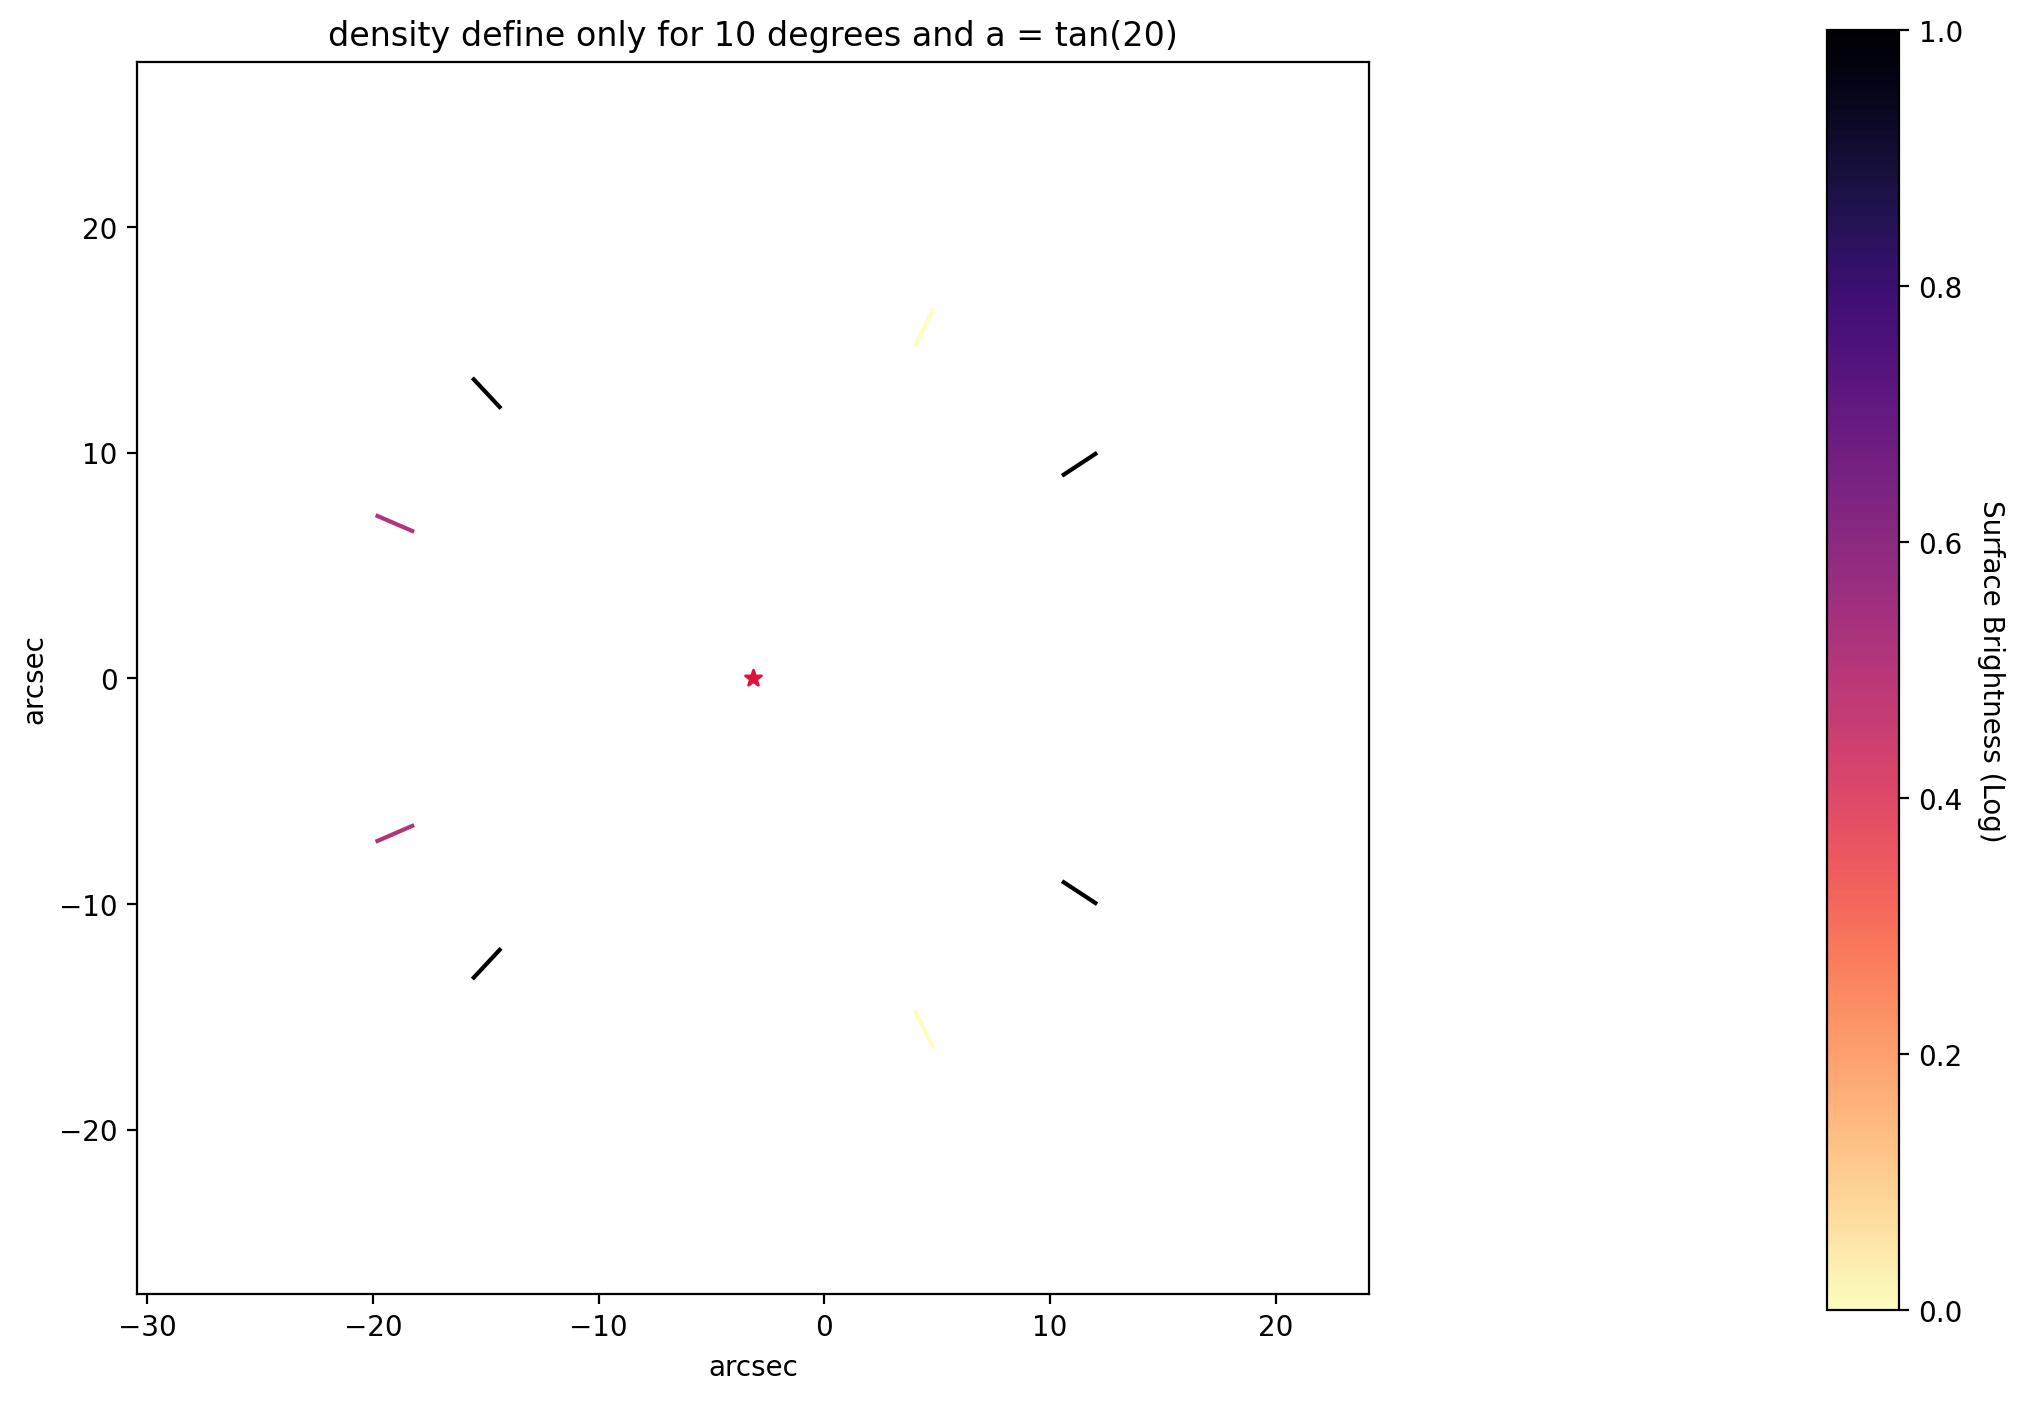

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%(delta_1, int(np.rad2deg(np.arctan(a)))))

limit_max = np.max([r_le])
# limit_min = np.min([limit_min_1, limit_min_h])


r_le_arc = np.arctan(limit_max / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "crimson")


cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()

In [16]:
alpha = 330 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

In [17]:
new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(0, 360, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)

  # new_xs, new_ys, new_xs_h, new_ys_h, surface, act, r_le, a = rude_function_delta_dependence(delta = deltas, alpha = 330, z0 = 0.3)
  # new_xs_list.append(new_xs)
  # new_ys_list.append(new_ys)
  # new_xs_h_list.append(new_xs_h)
  # new_ys_h_list.append(new_ys_h)
  # surface_list.append(surface)

<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: divide by zero encountered in divide
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


In [18]:
new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)

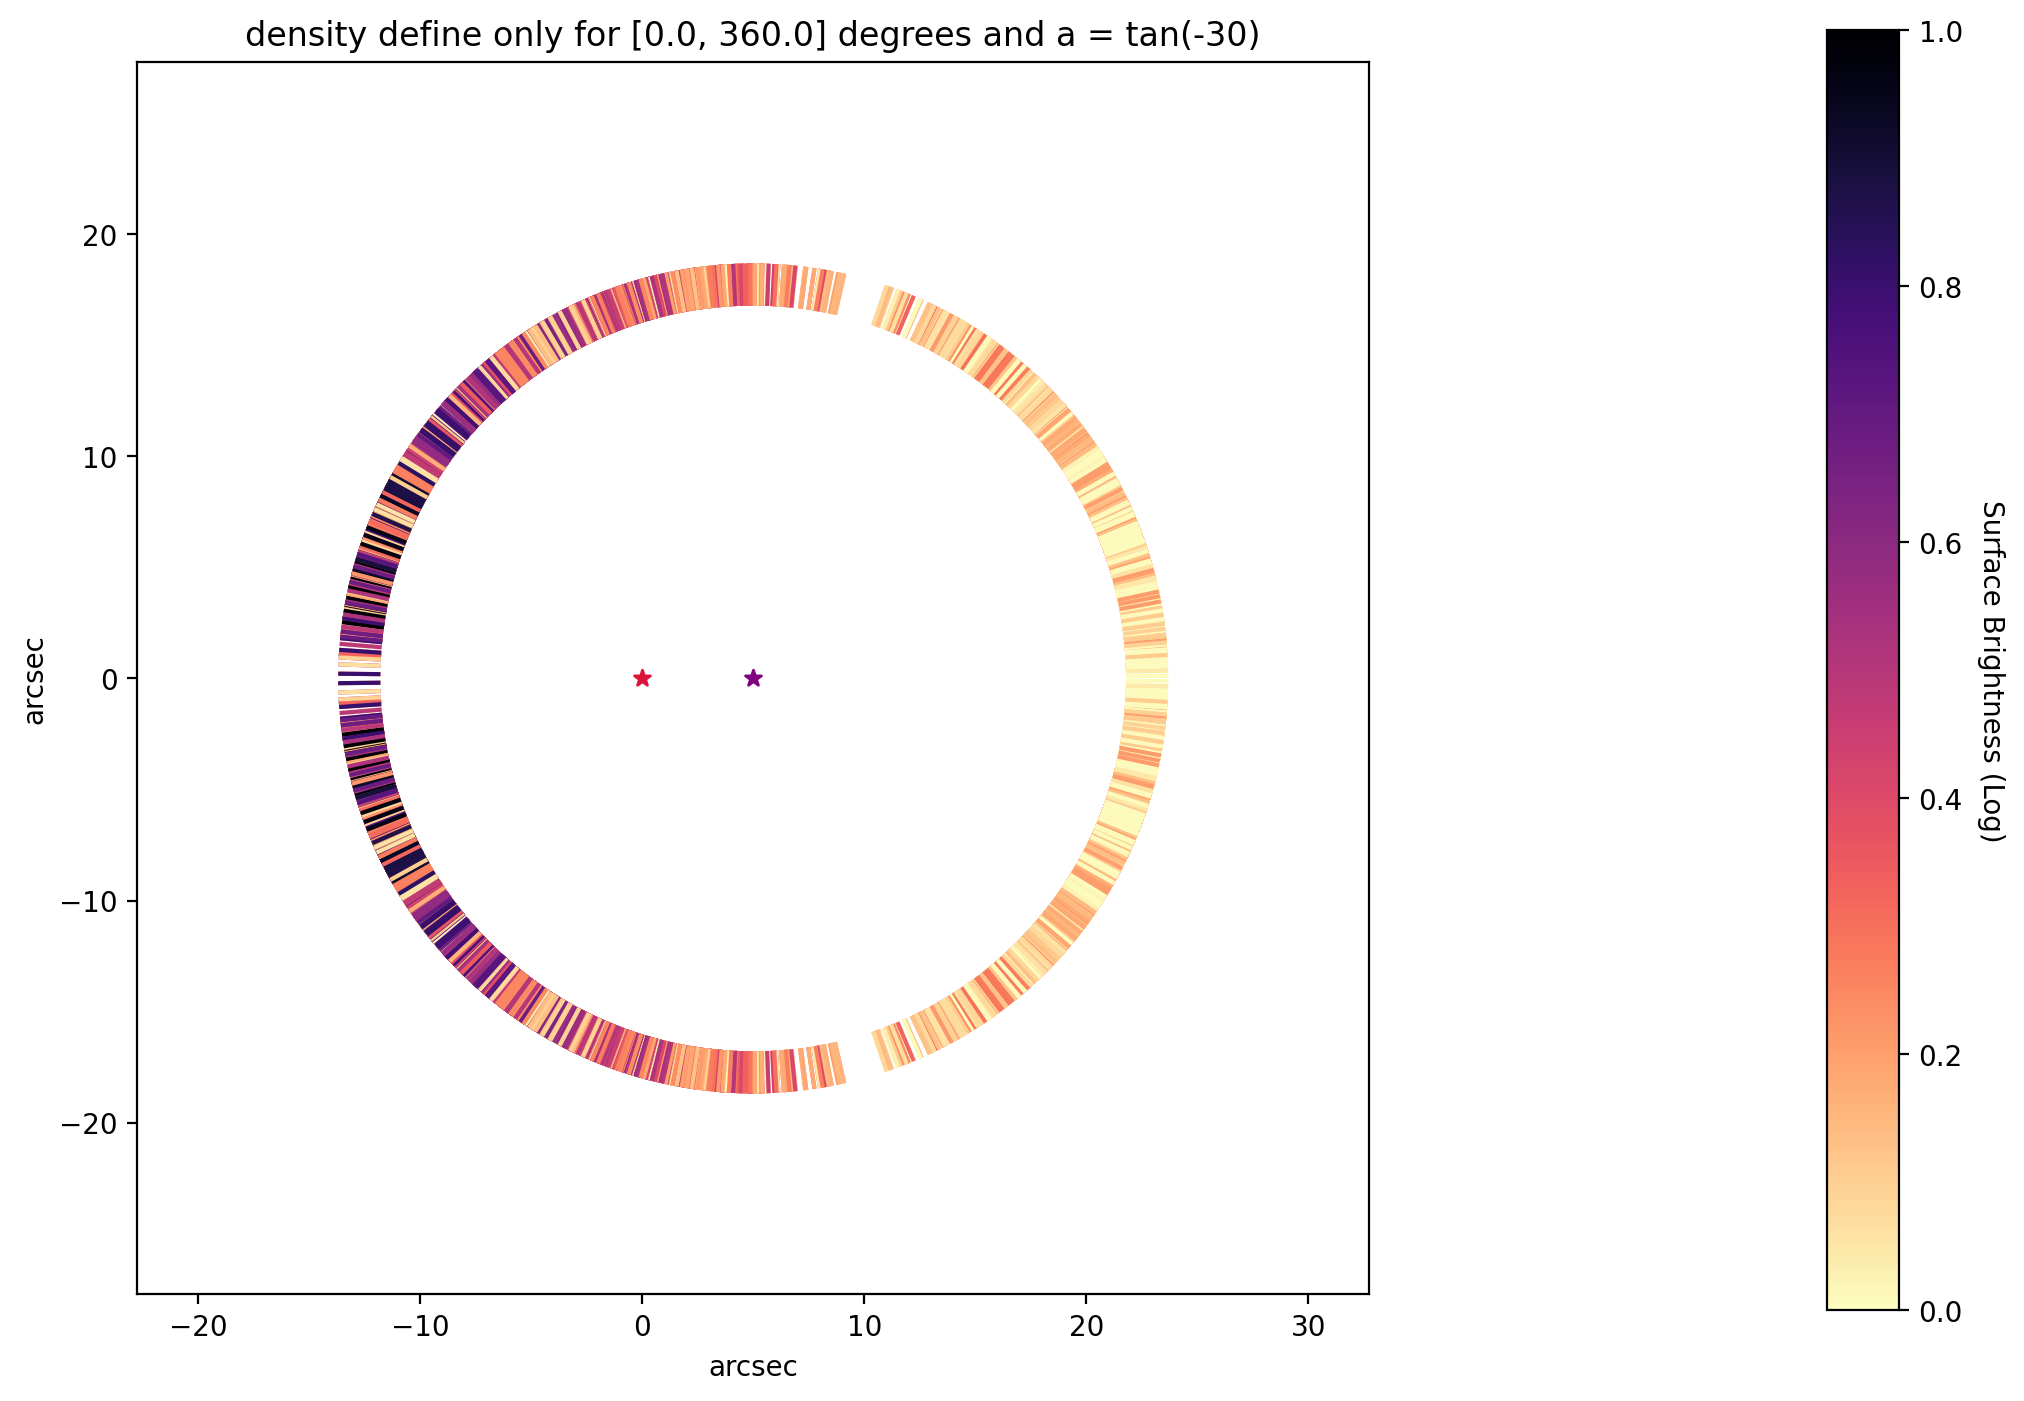

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()

In [20]:
alpha = 10 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(0, 360, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)

<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: divide by zero encountered in divide
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


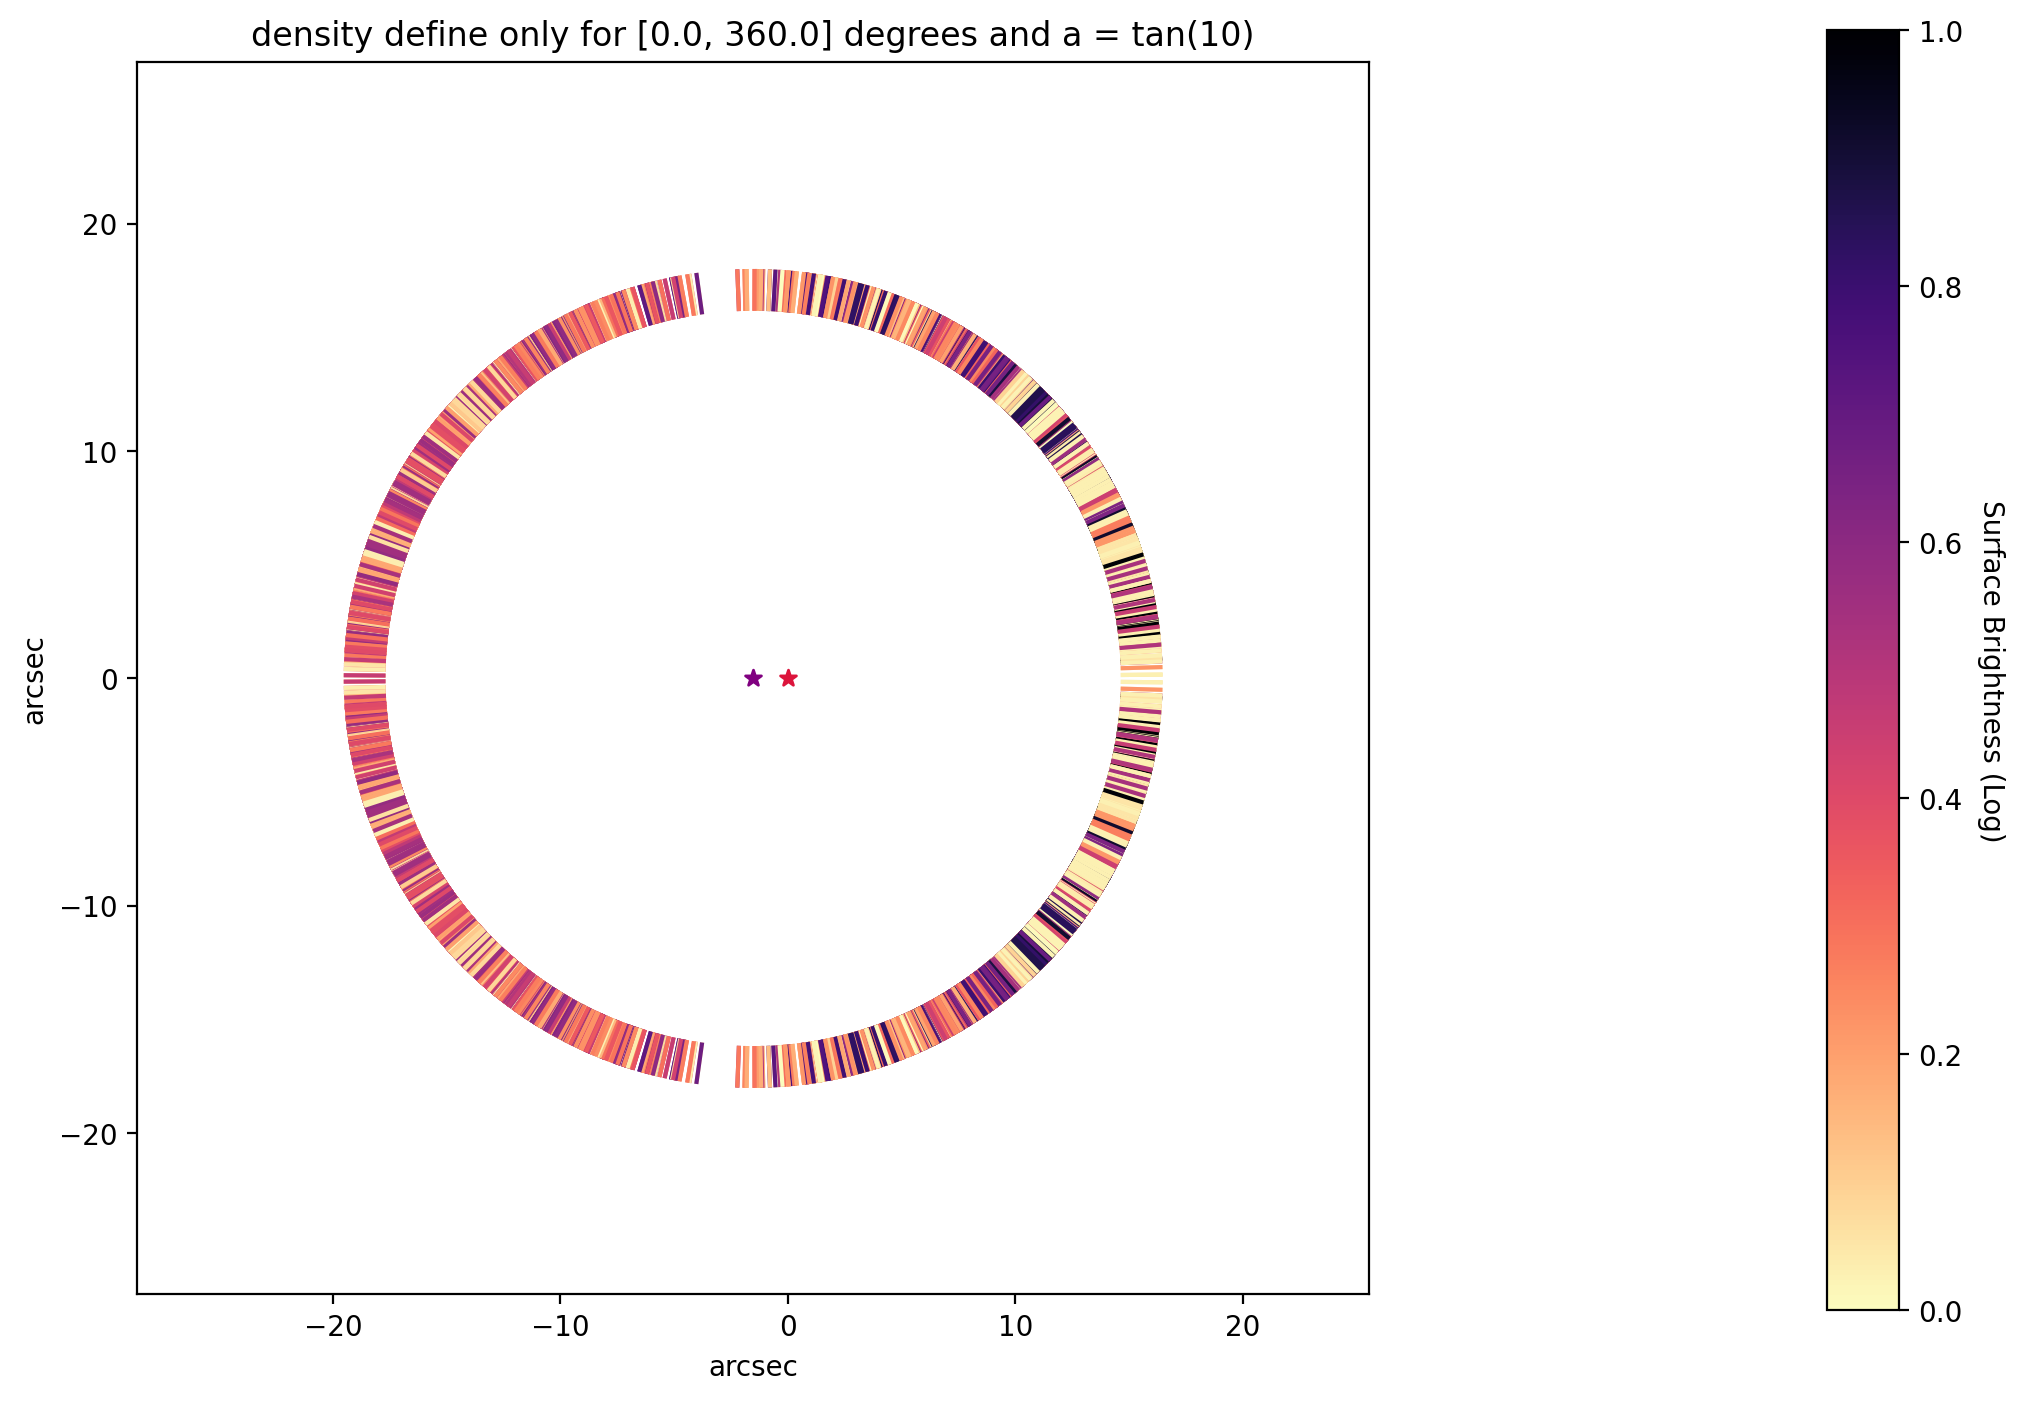

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()

<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: divide by zero encountered in divide
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


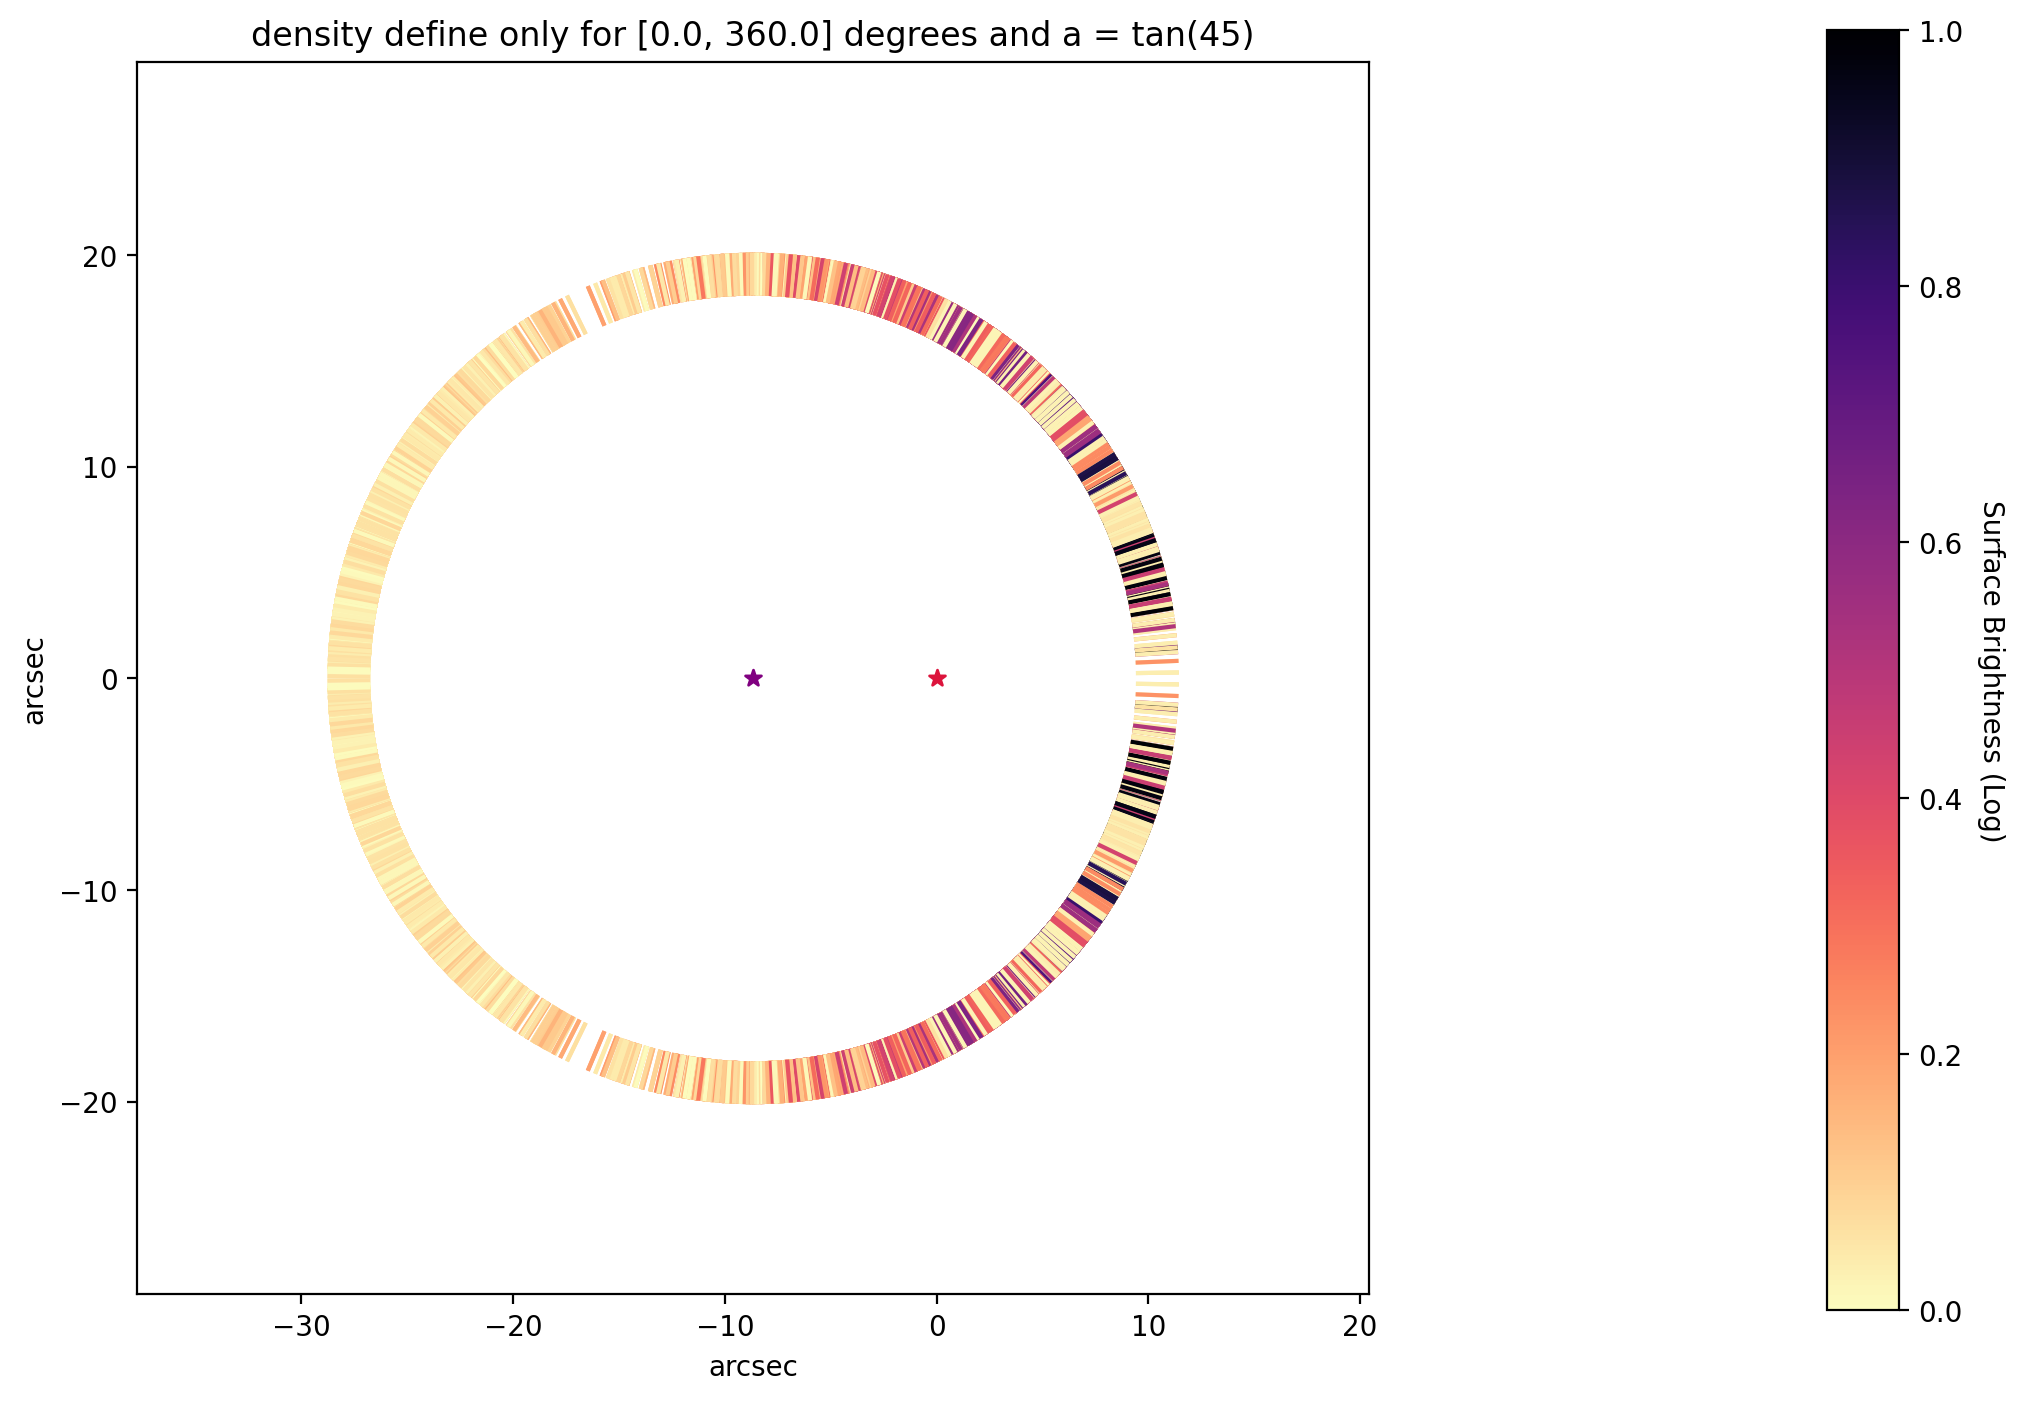

In [22]:
alpha = 45 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(0, 360, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: divide by zero encountered in divide
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


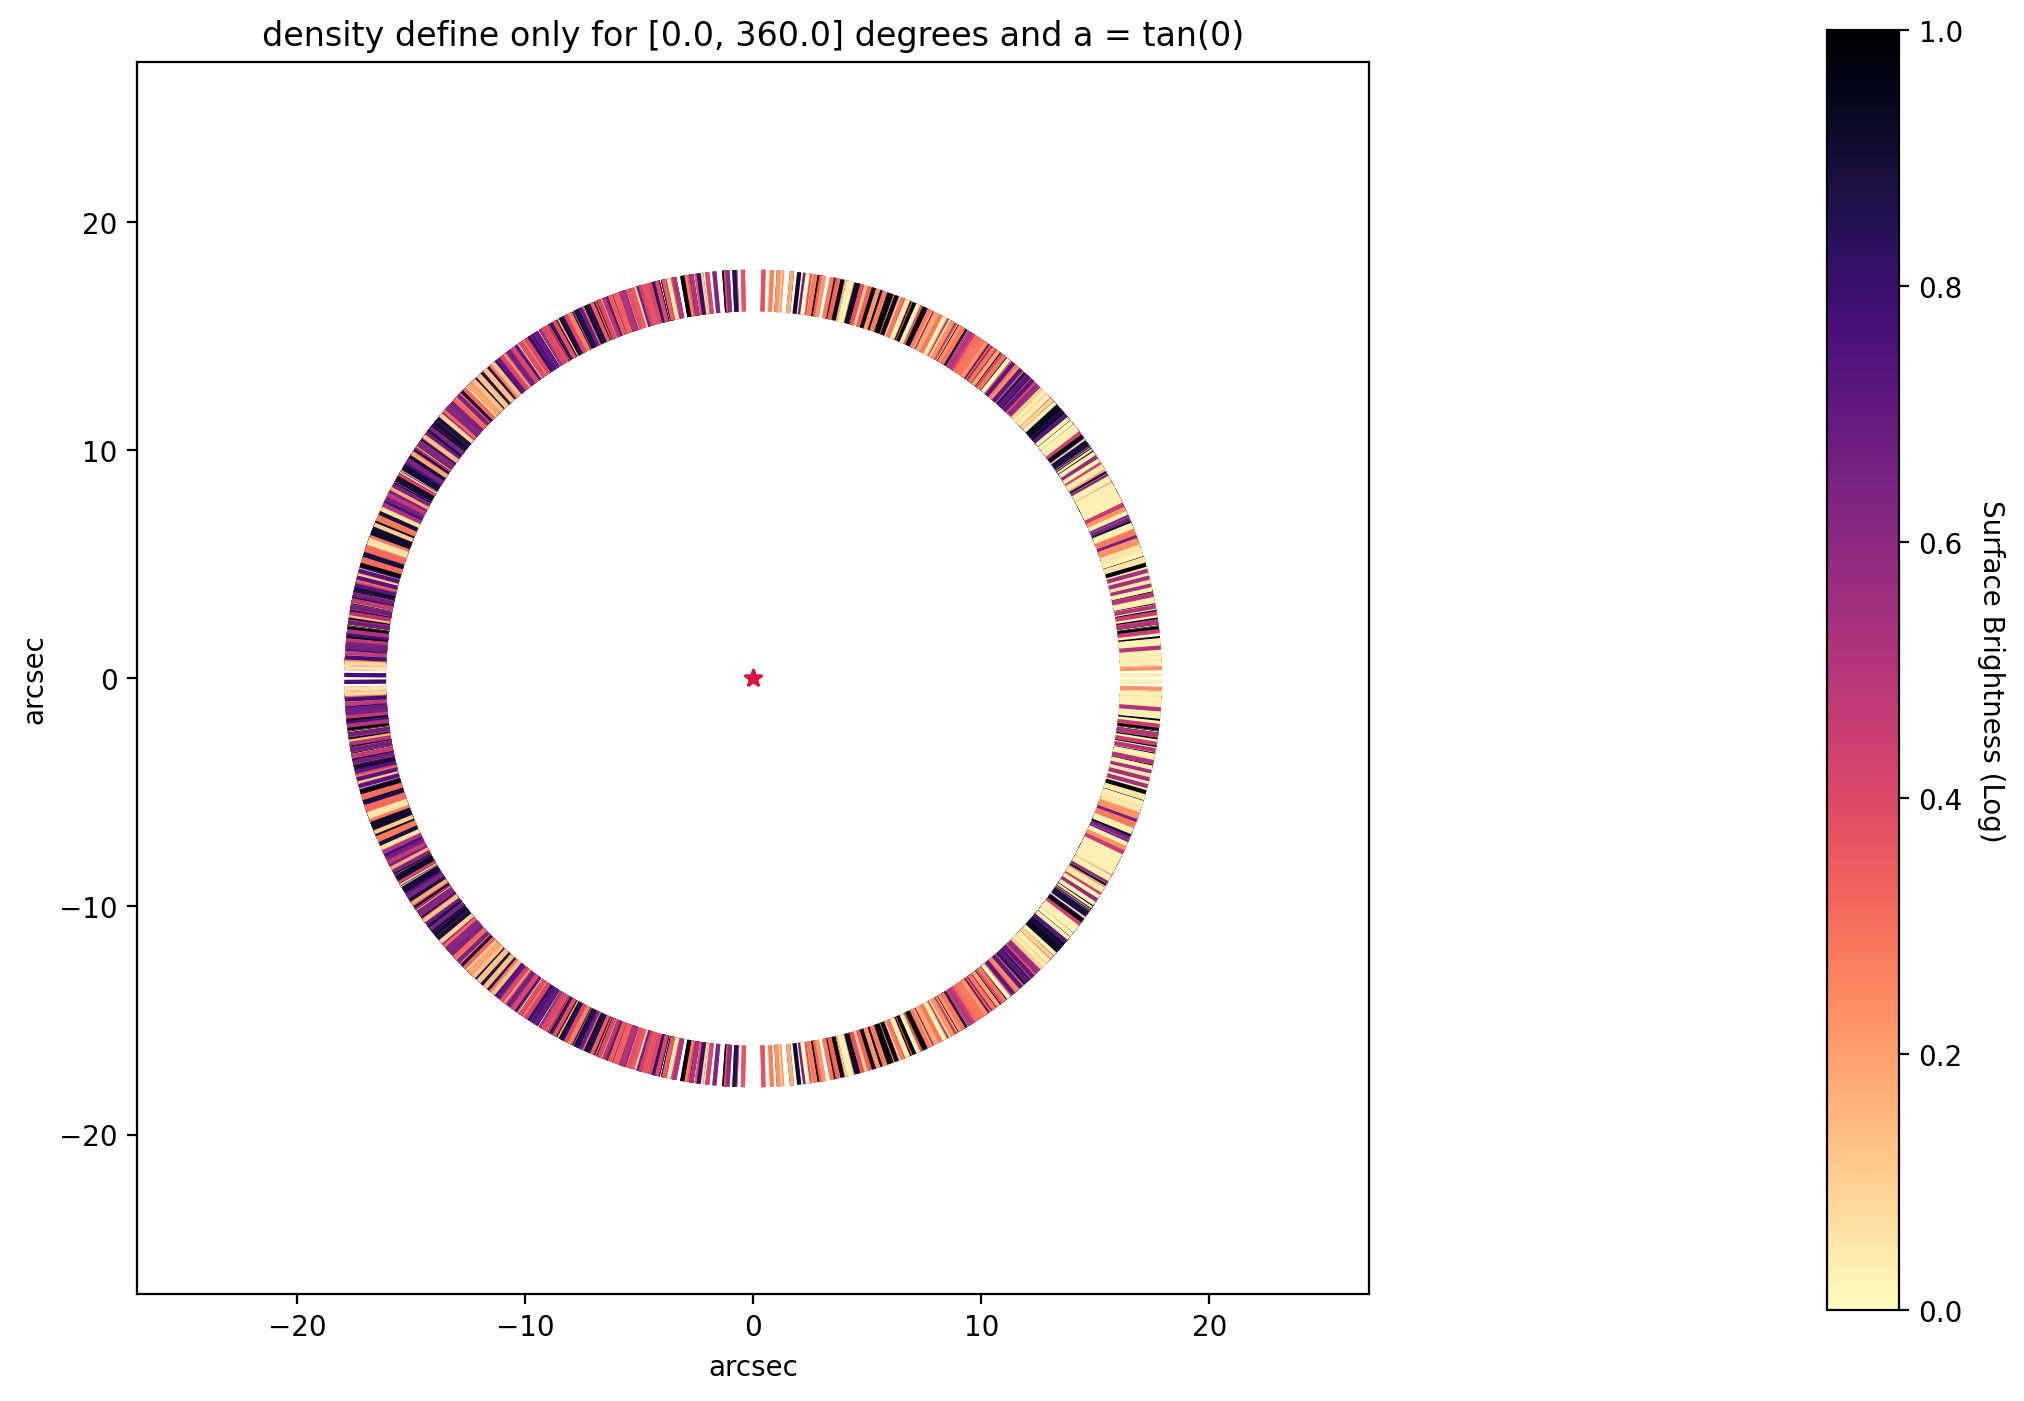

In [23]:
alpha = 0 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(0, 360, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


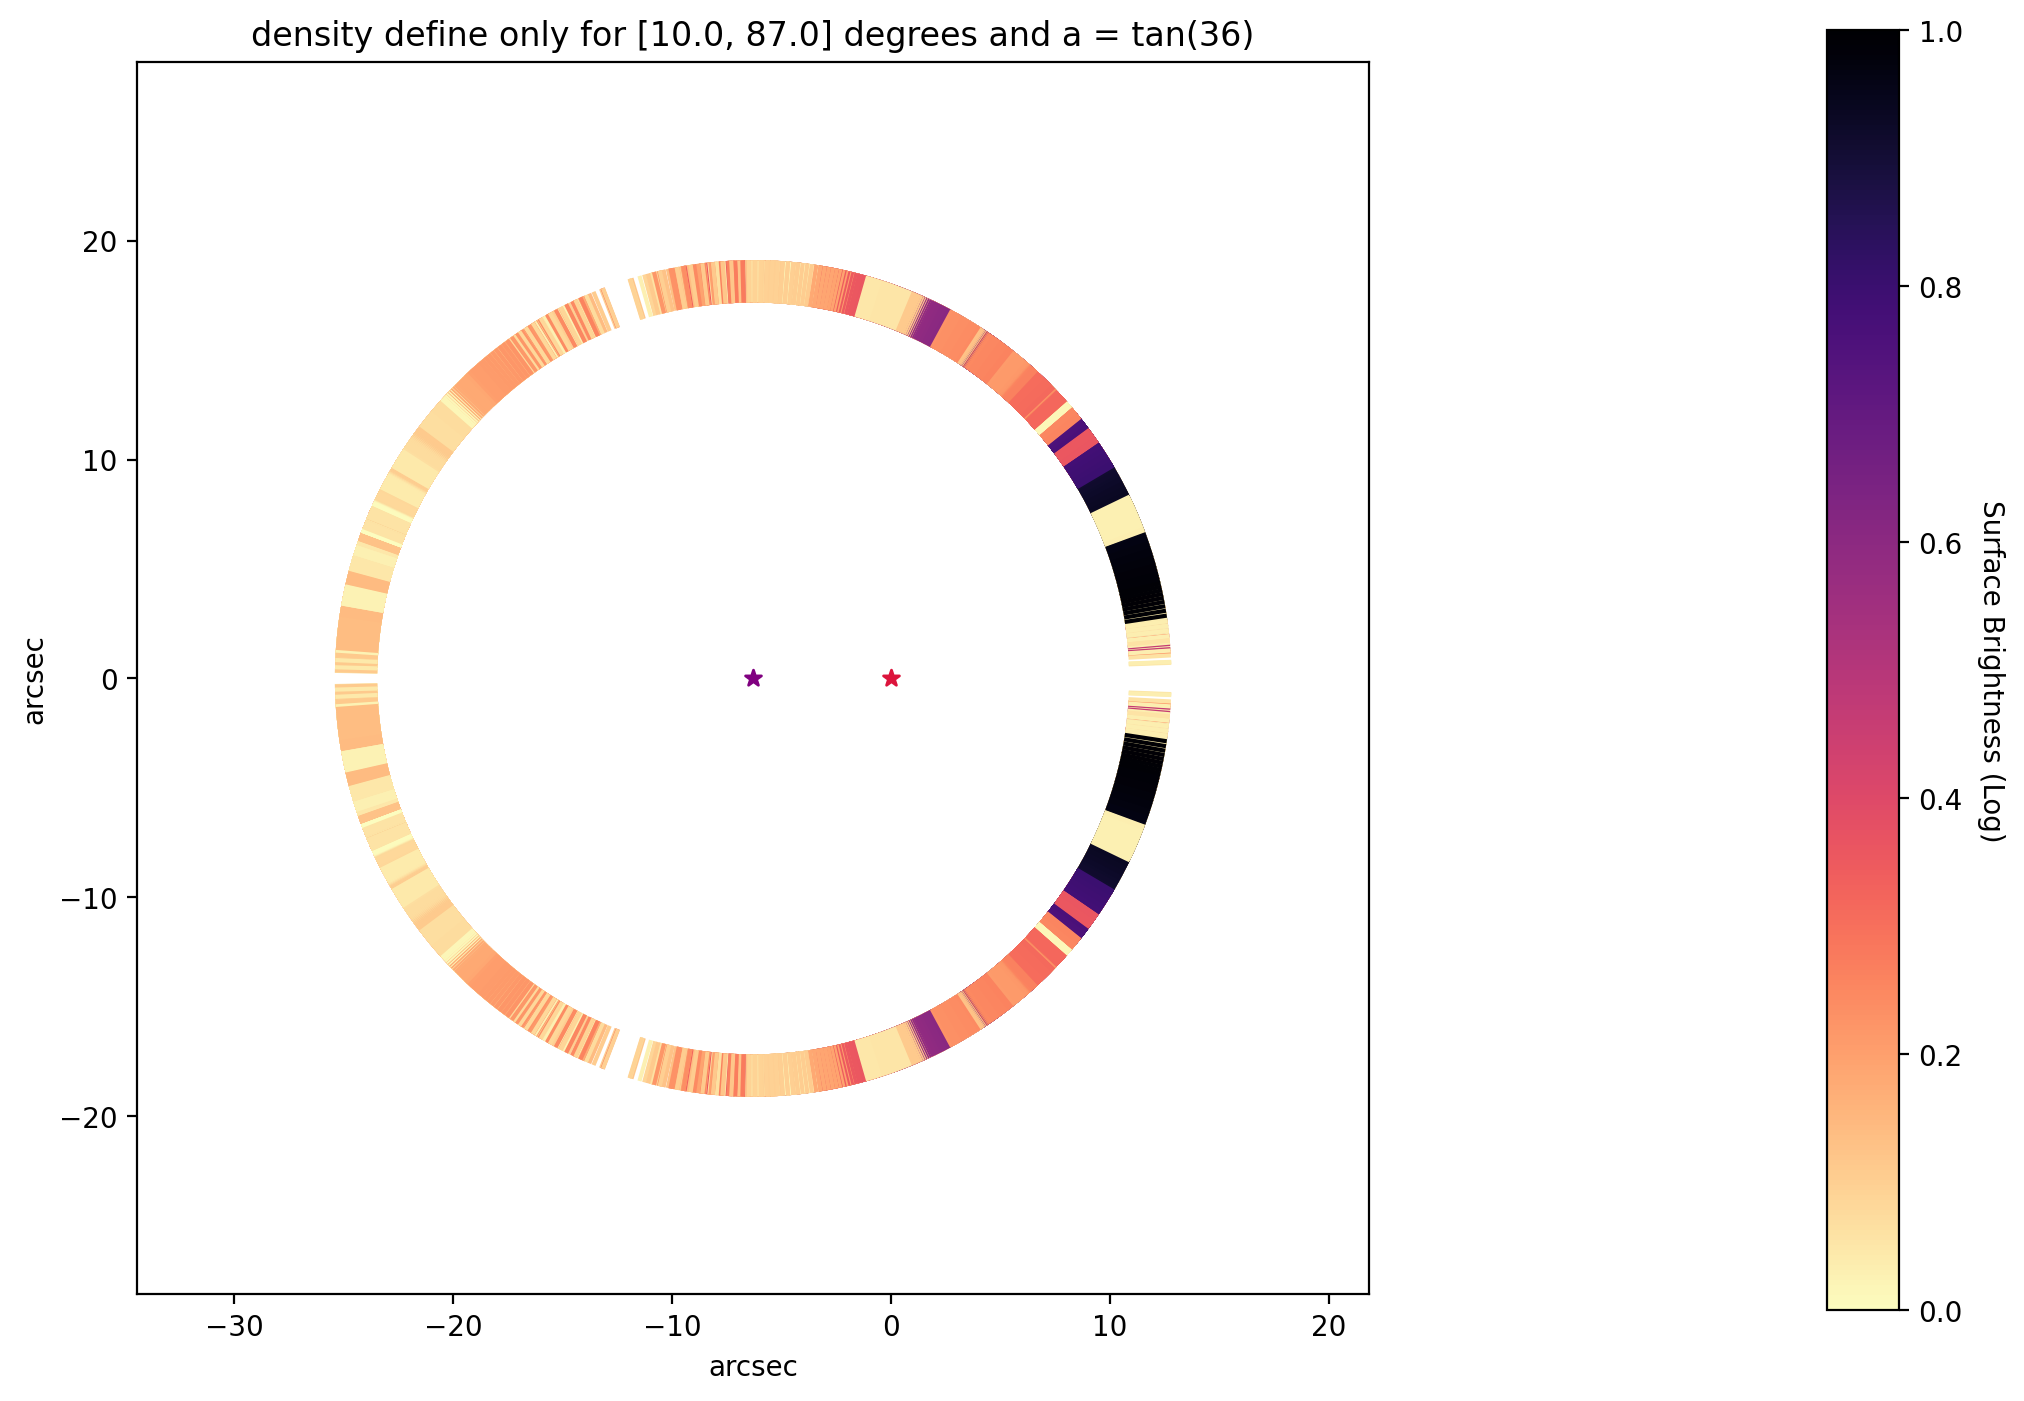

In [24]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(10, 87, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


In [25]:
new_xs

array([[[  0.18649484,  -8.25682496,   8.54700434, ..., -24.21966205,
         -24.64379057, -25.25777728],
        [ -0.40896793,  -8.07649056,   7.18335327, ..., -22.57261503,
         -22.95777336, -23.51534516]]])

<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


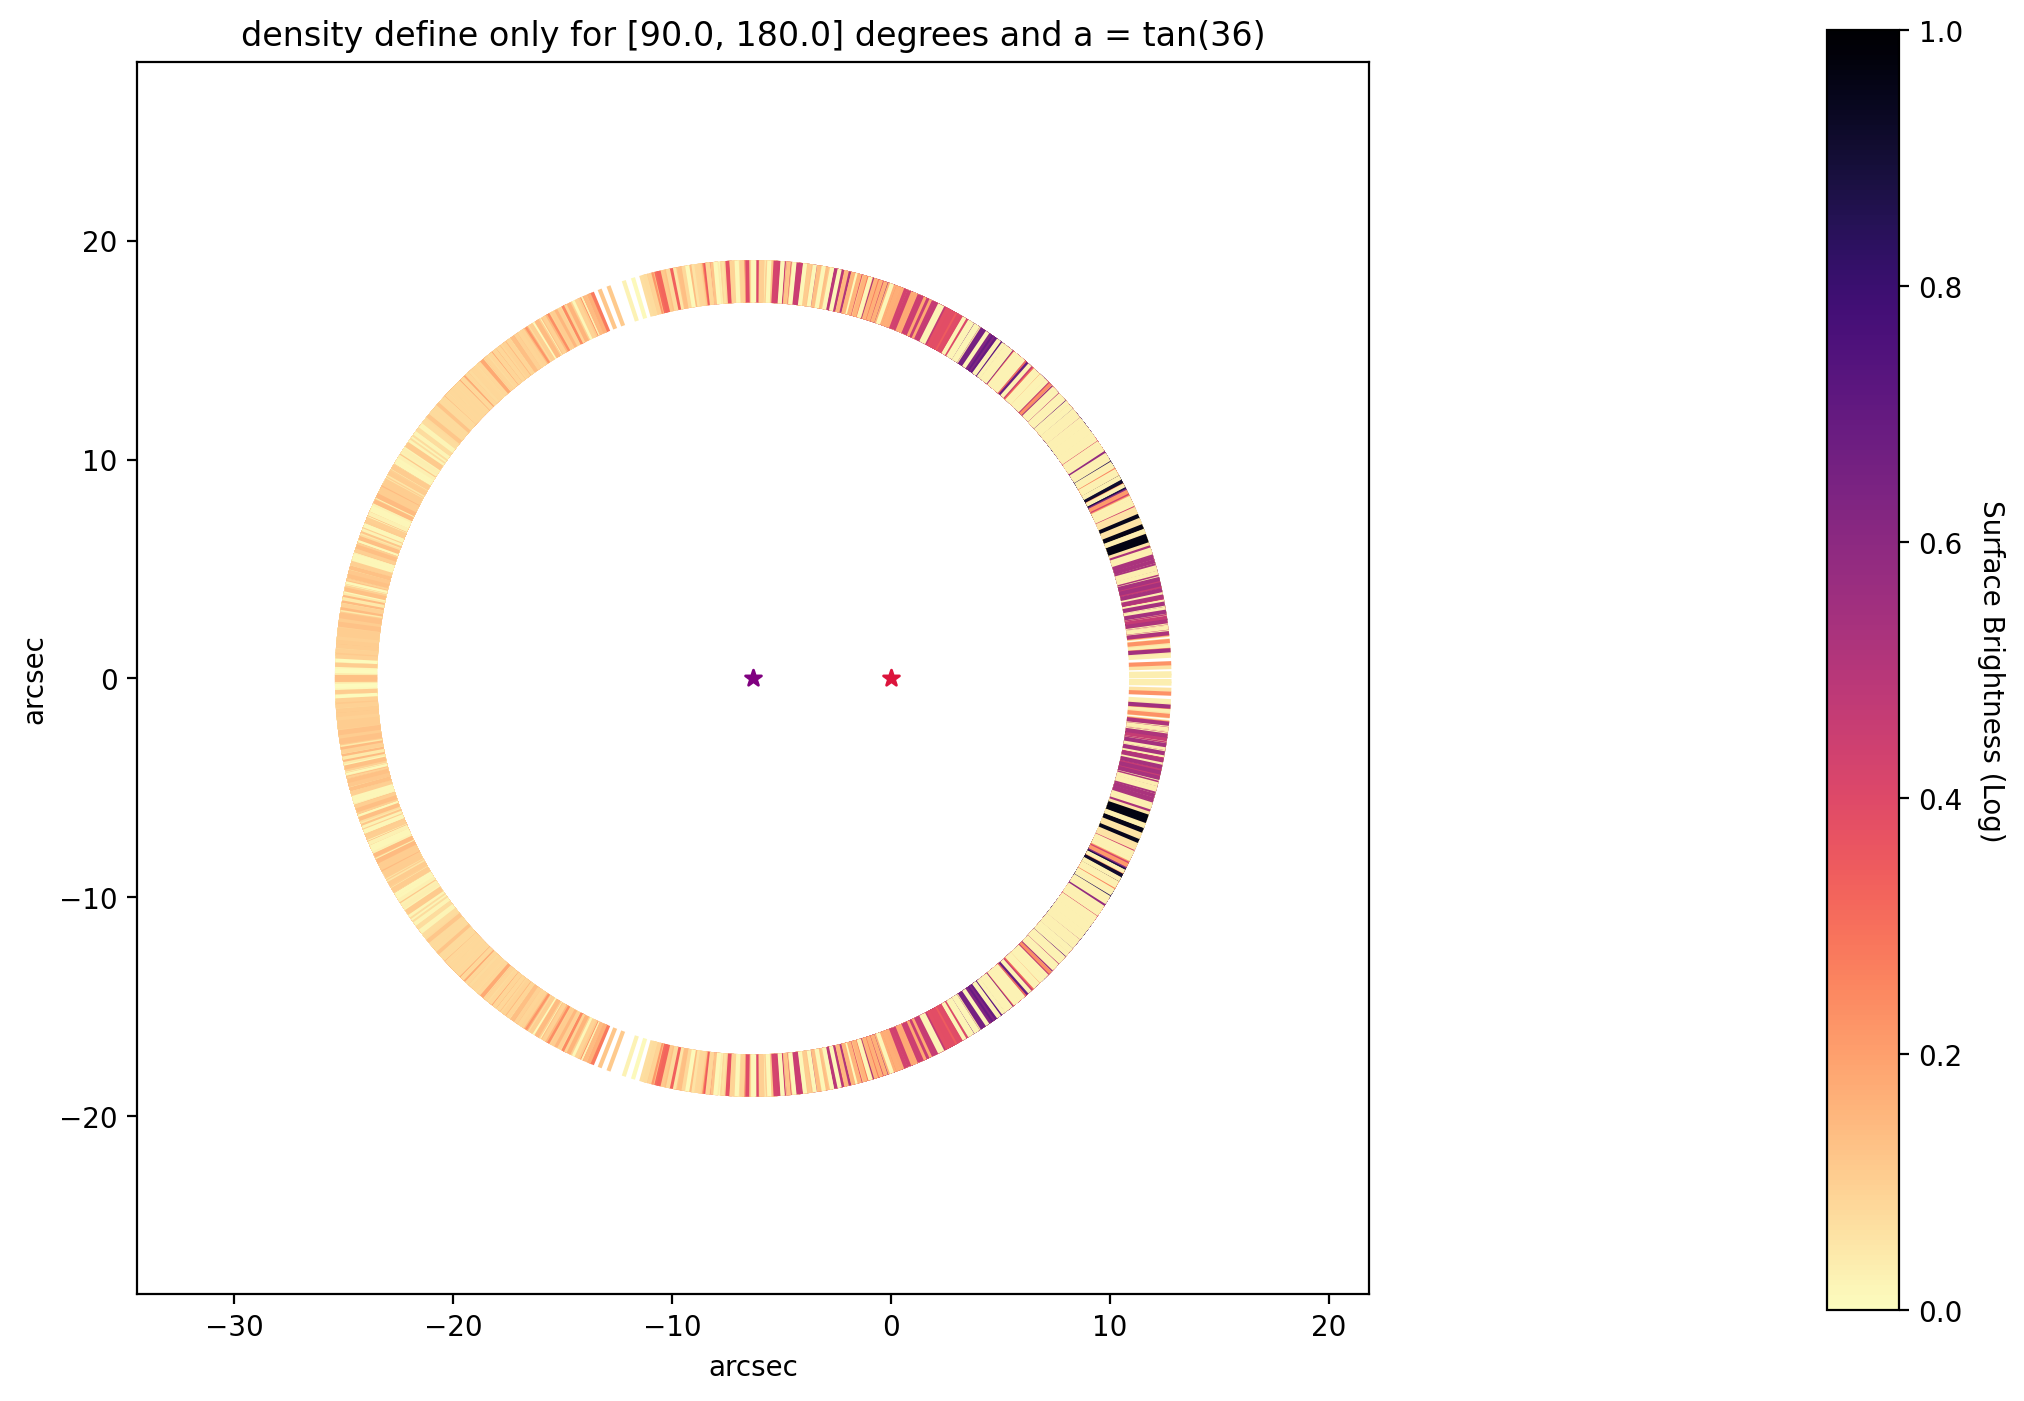

In [26]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(90, 180, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


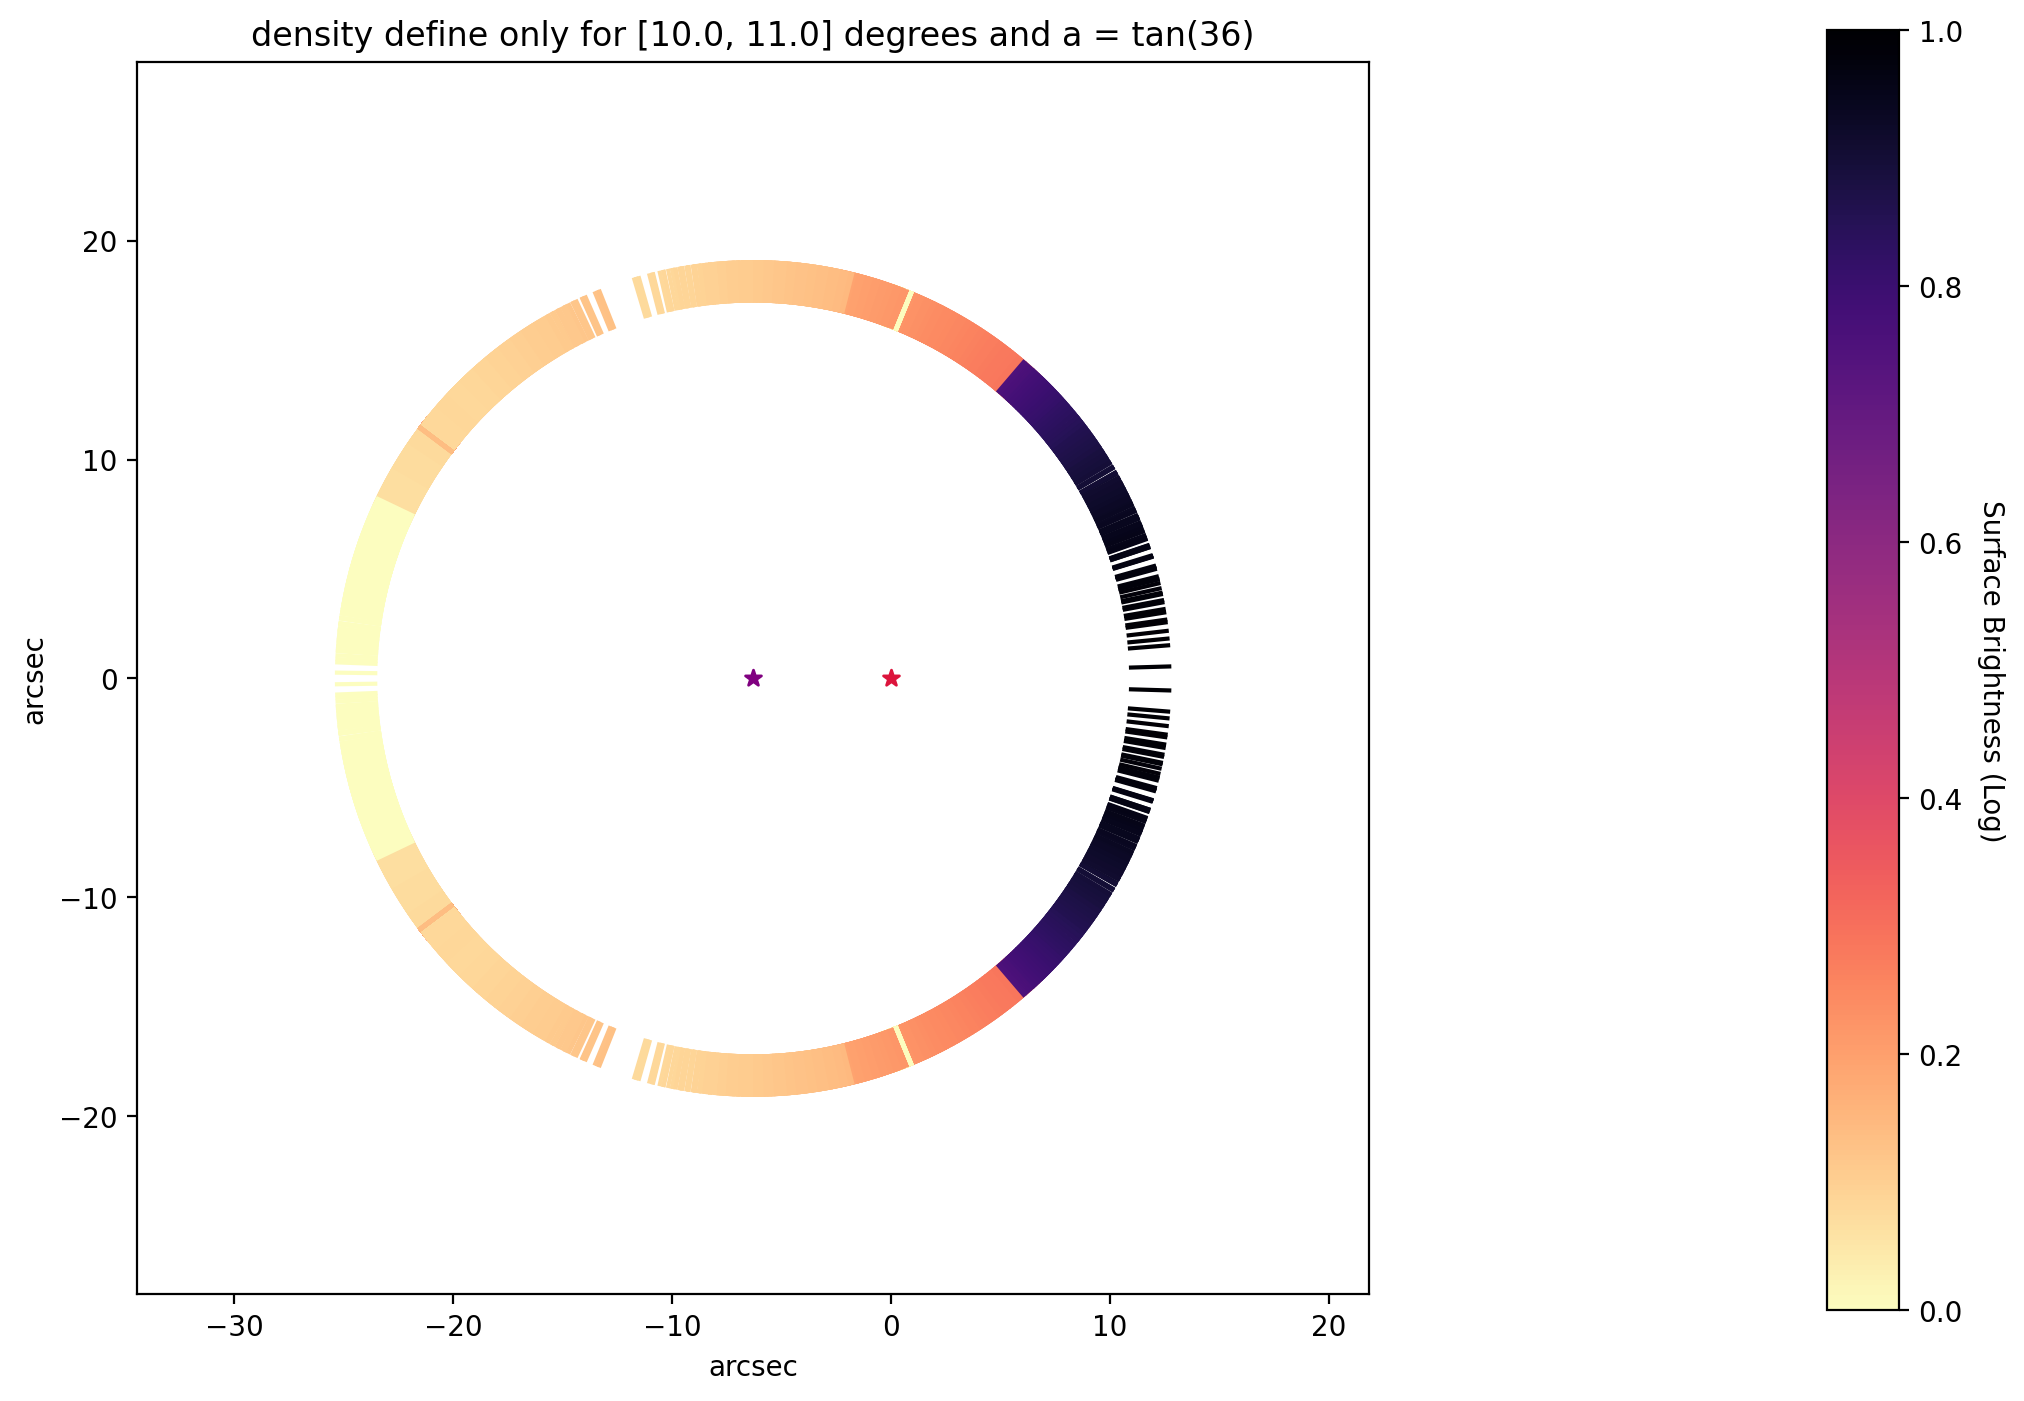

In [27]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(10, 11, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


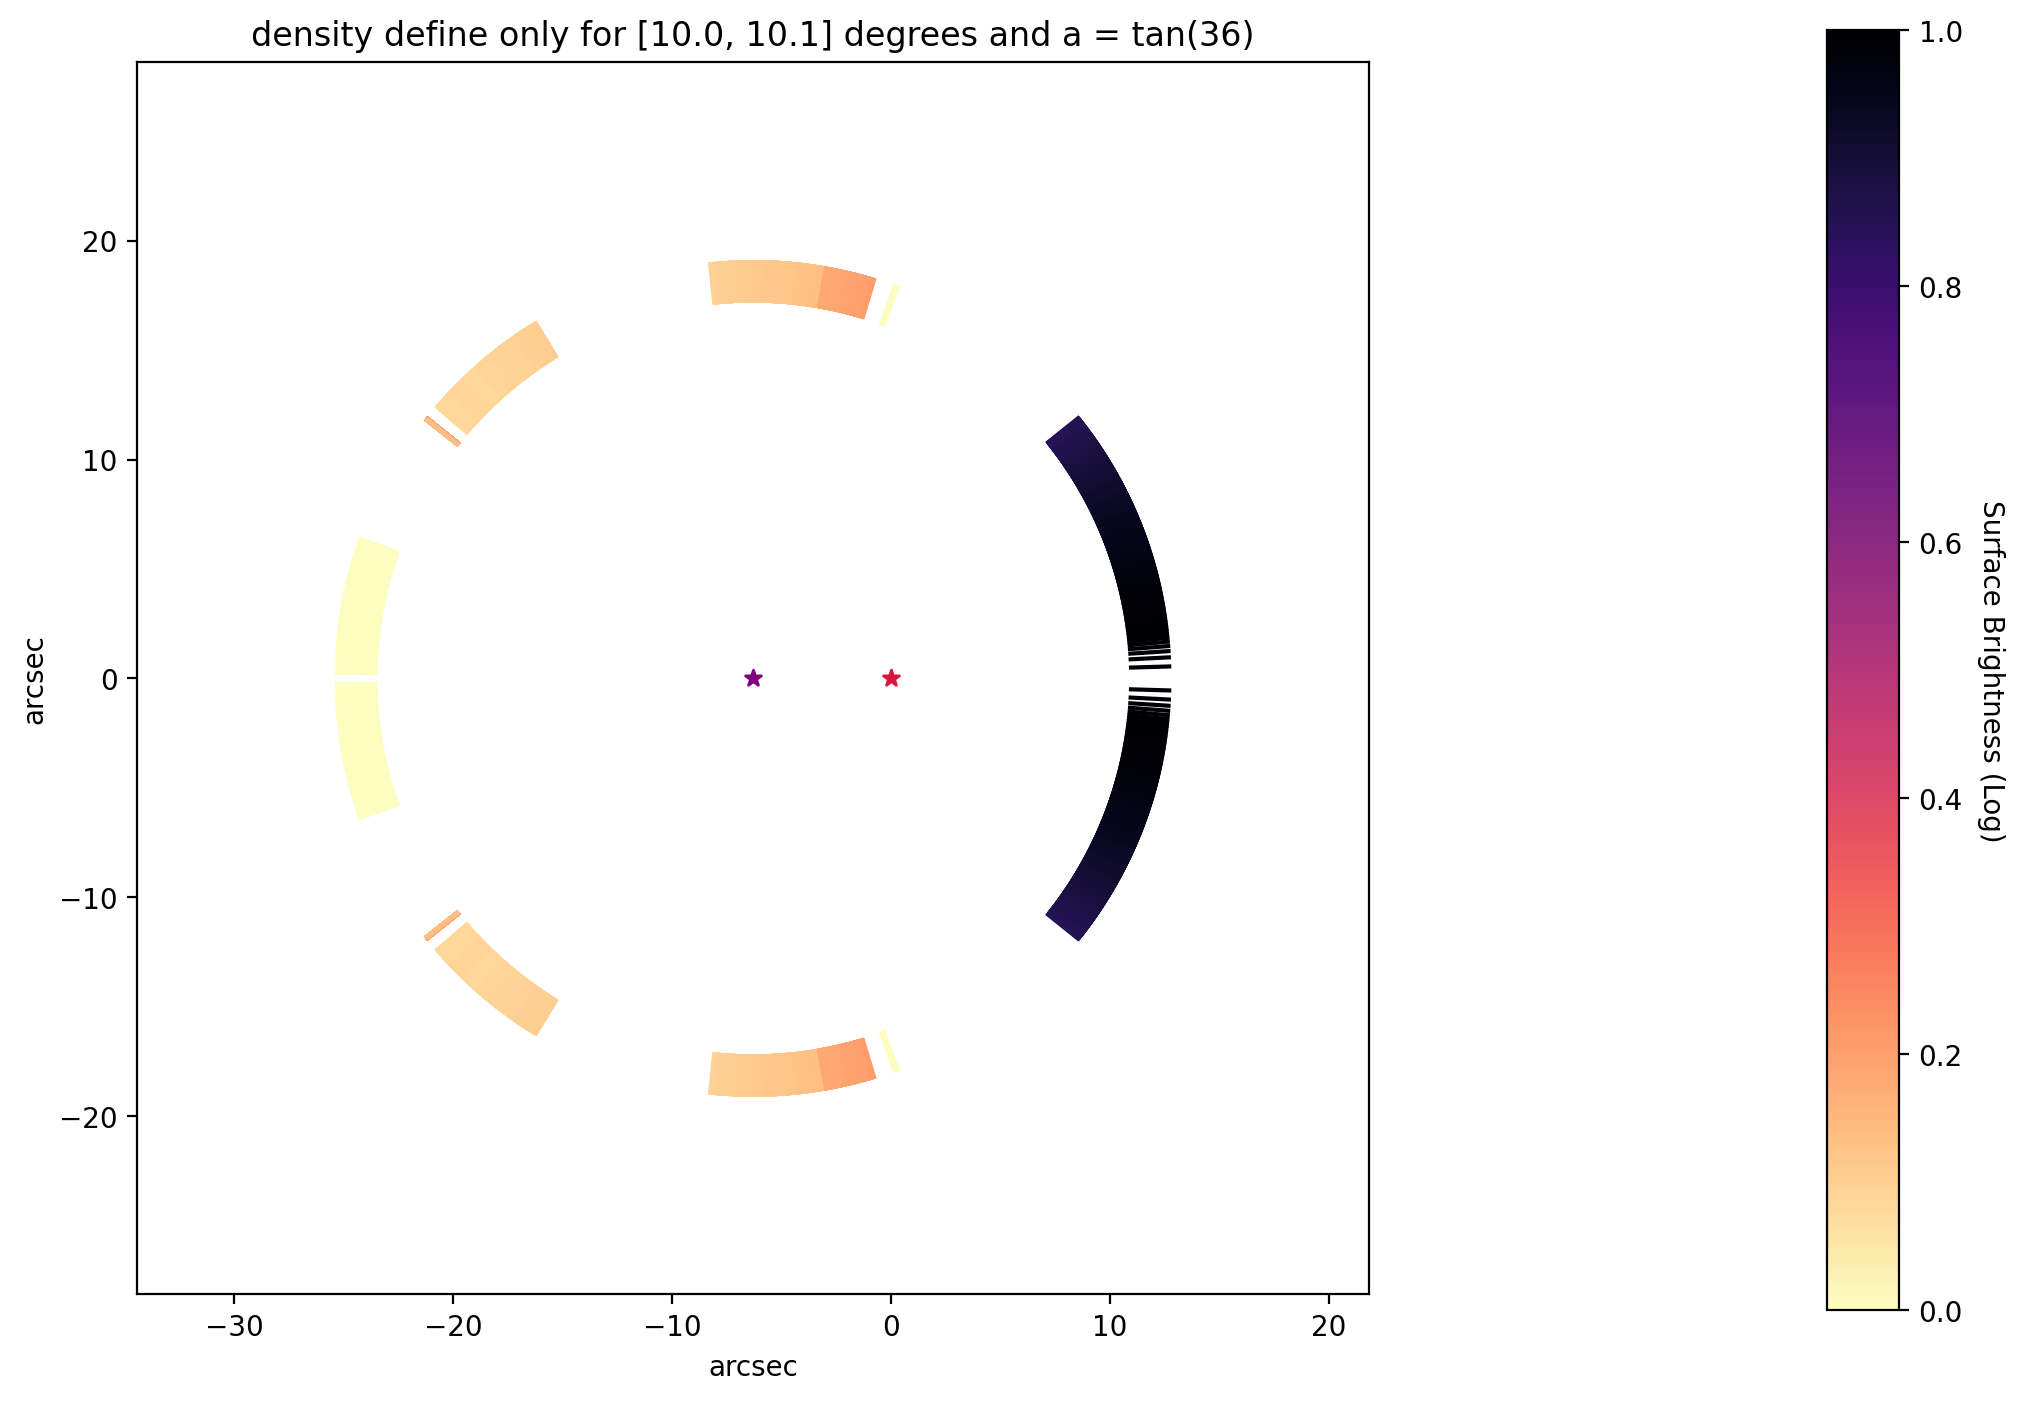

In [37]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(10, 10.1, 400)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


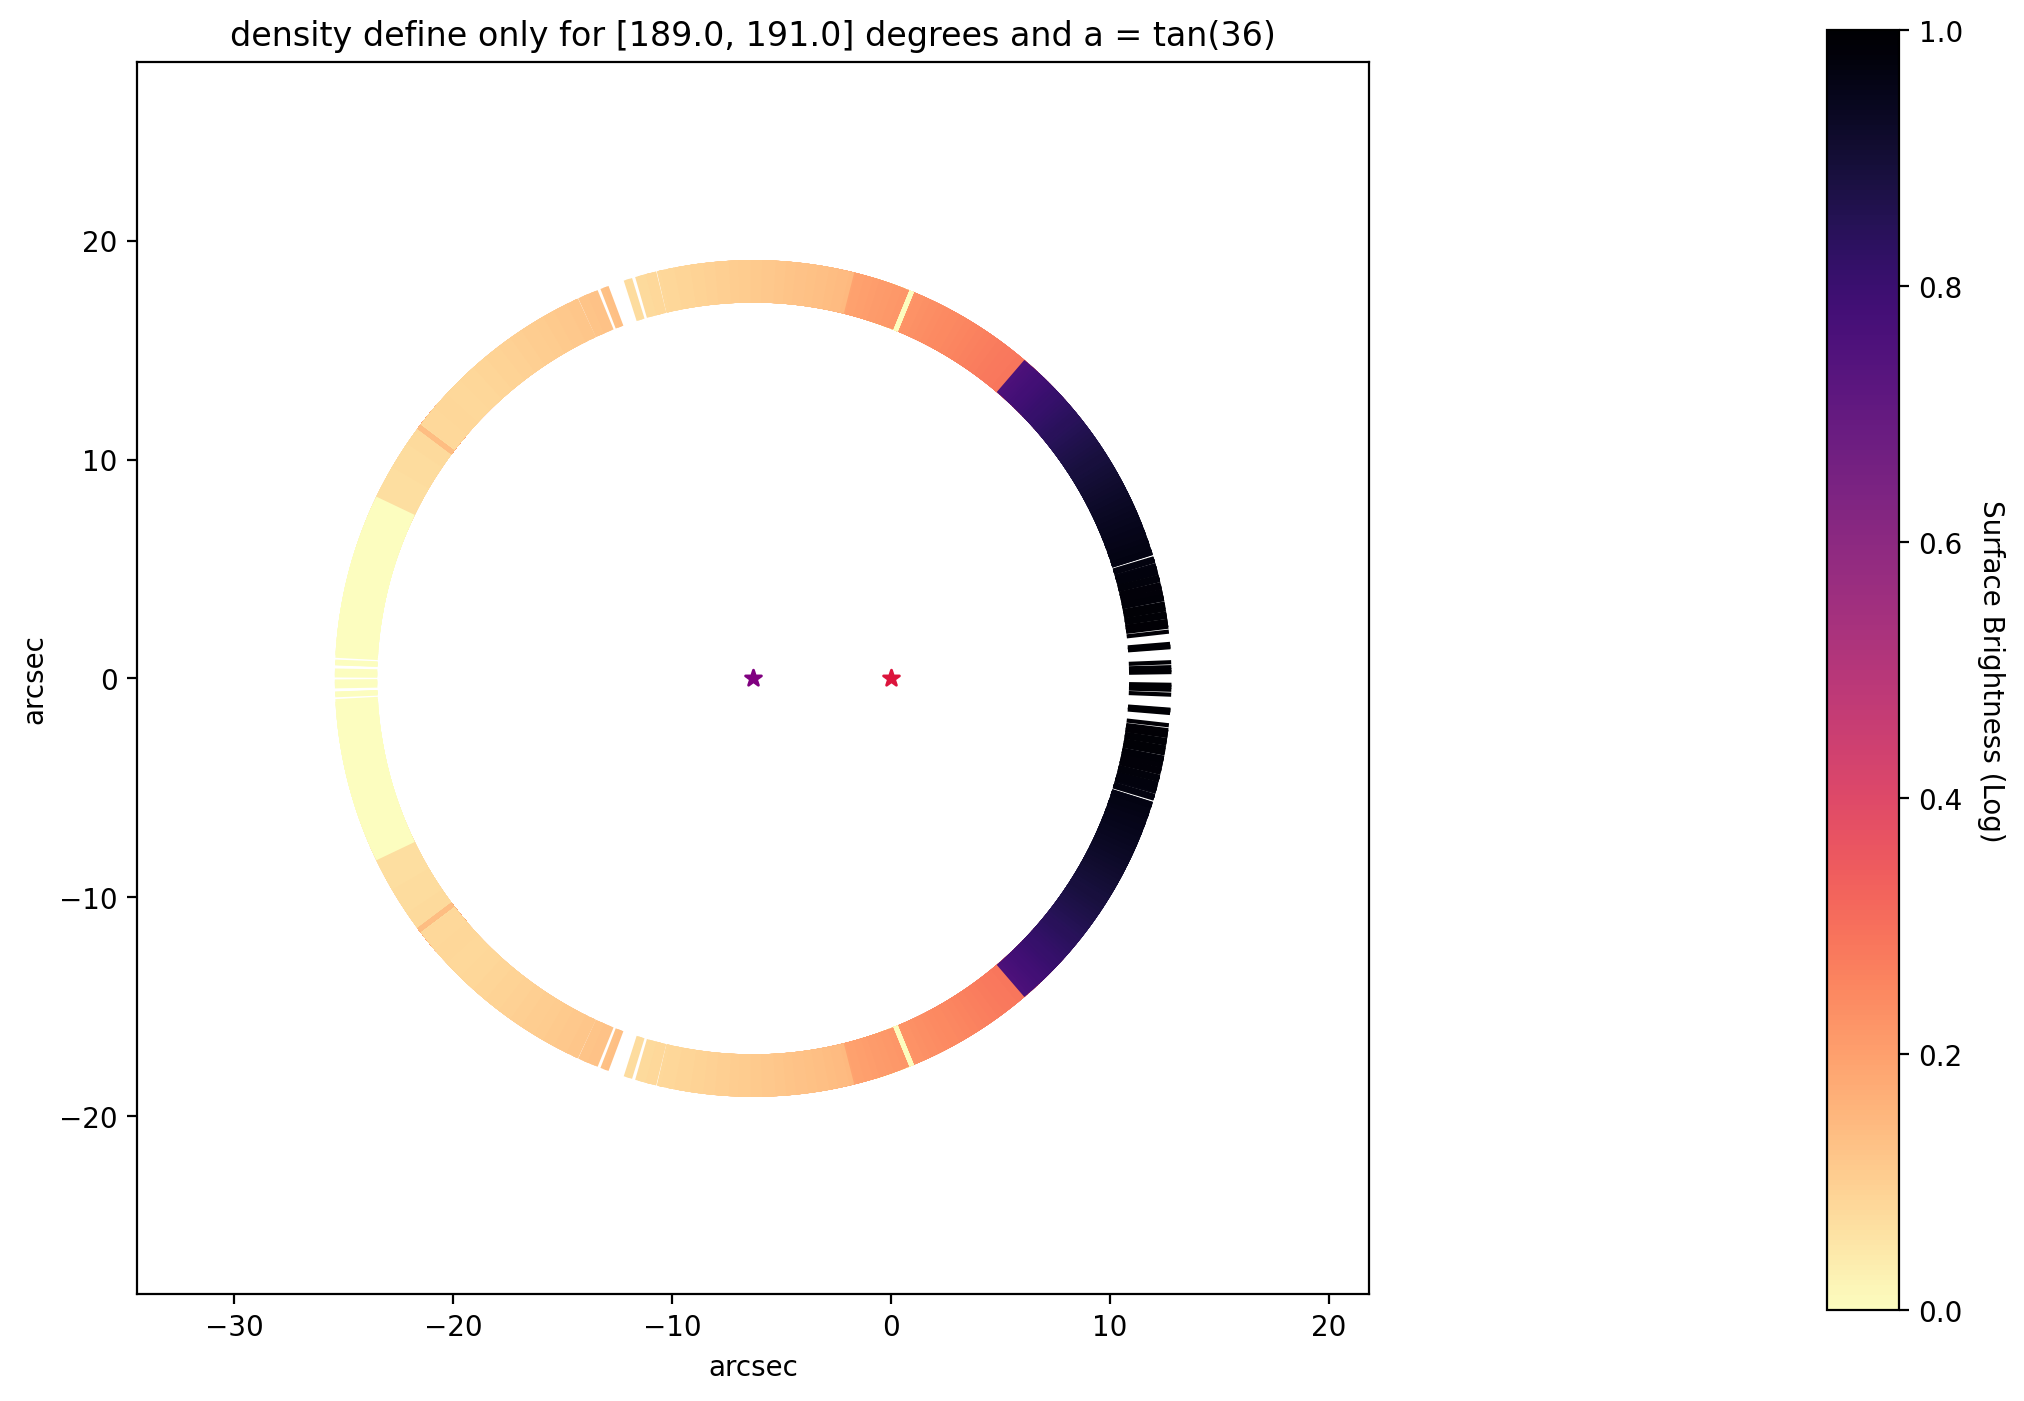

In [39]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(189, 191, 1000)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))


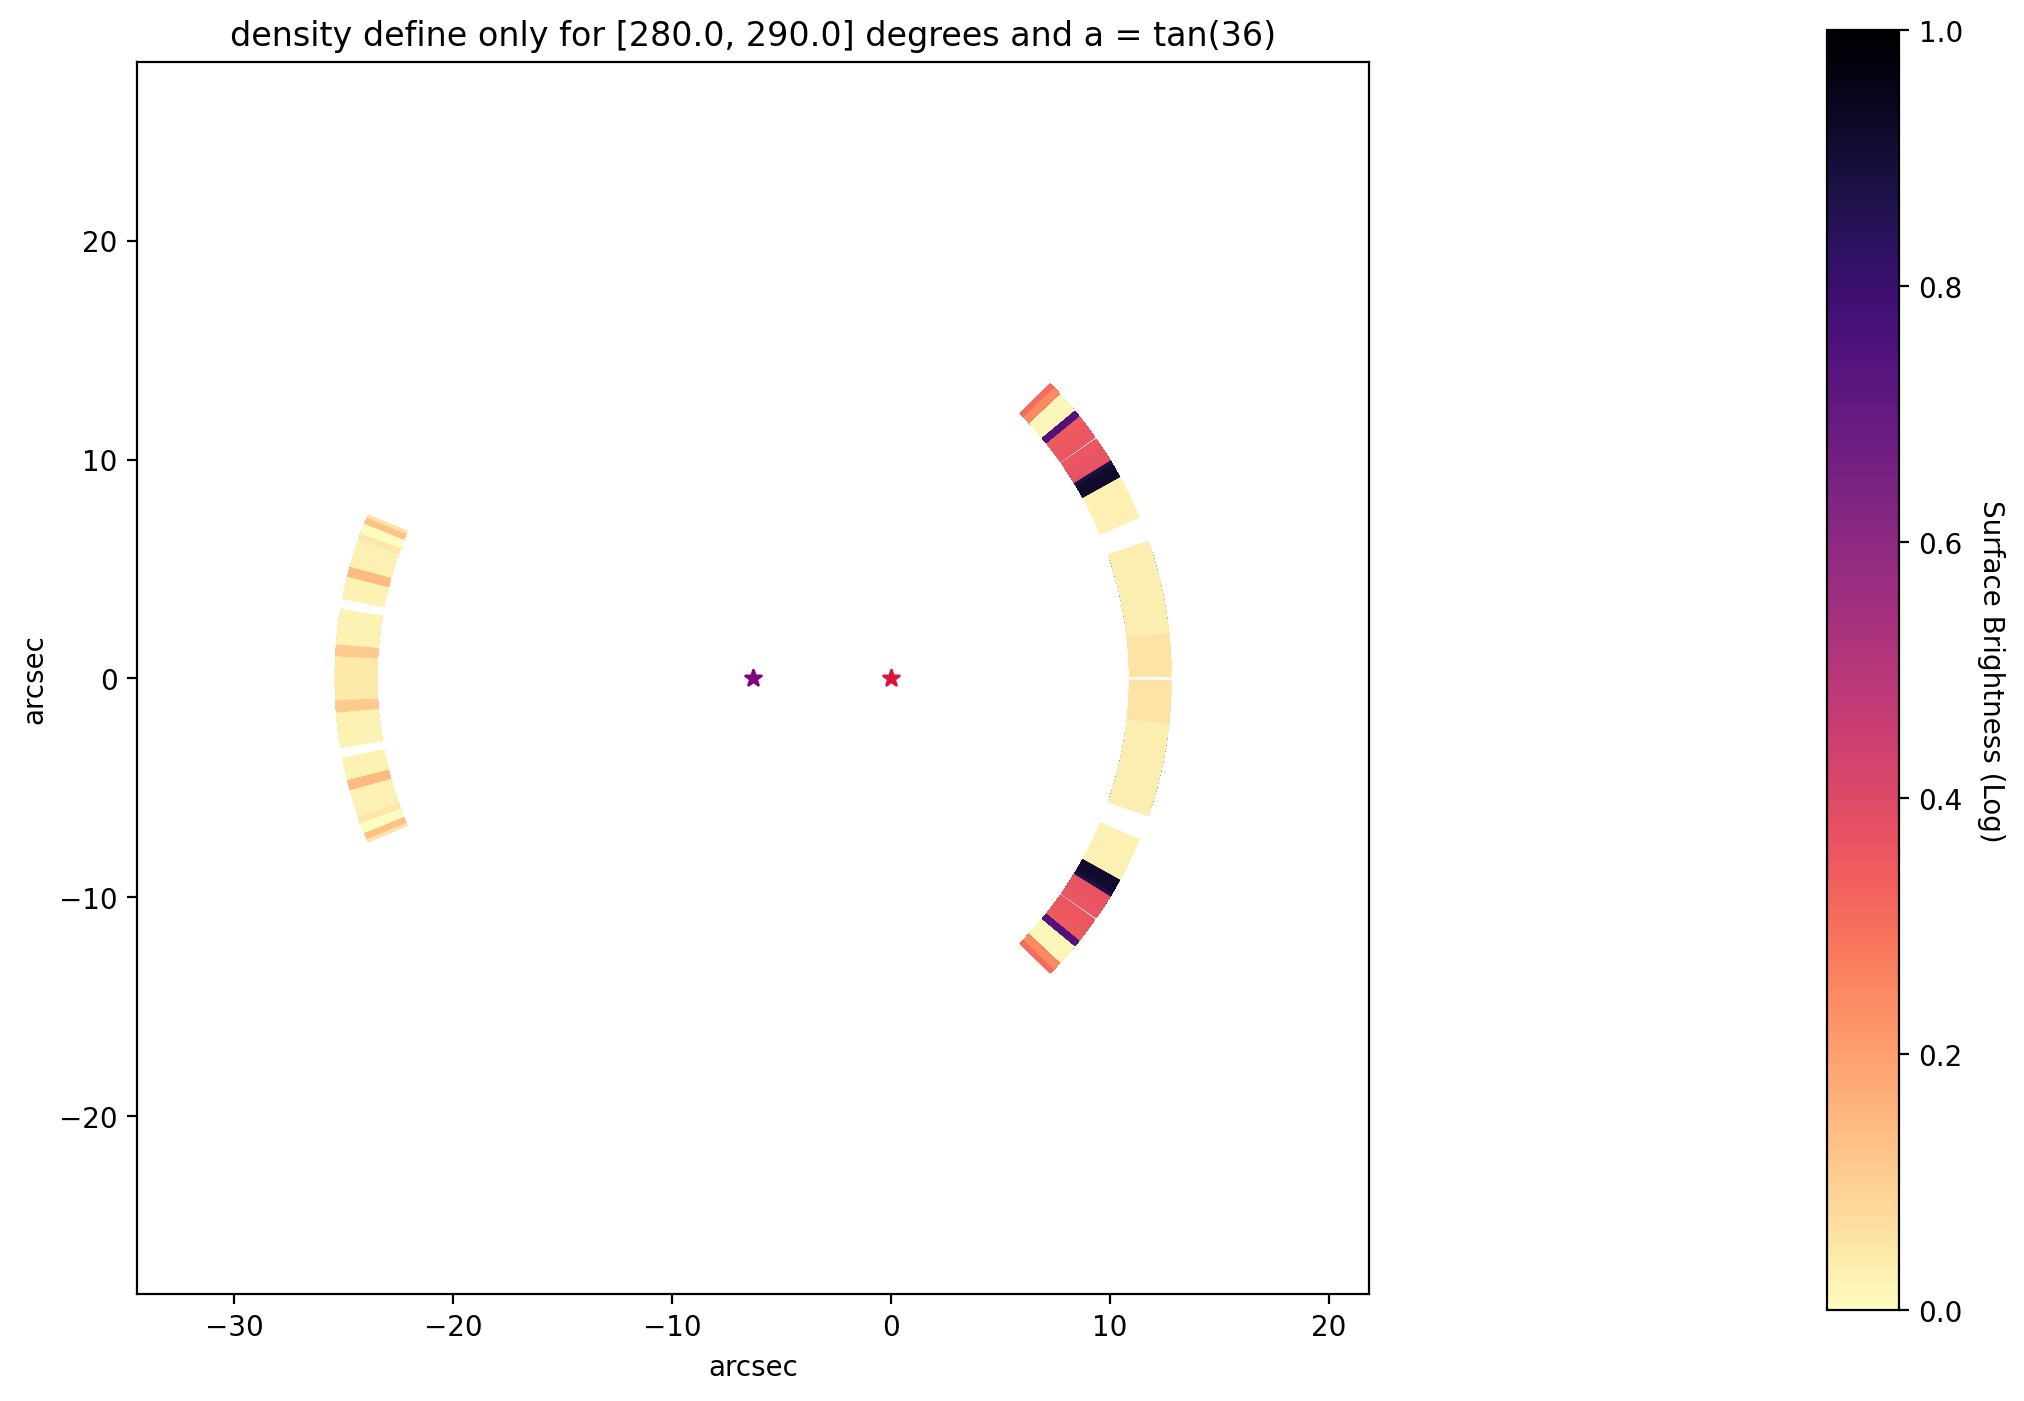

In [40]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
r_le2 = 2 * z0ly[2] * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(280, 290, 1000)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly[2], a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()


In [43]:
alpha = 36 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
z0ly = -0.1 * pctoly # ly
r_le2 = 2 * z0ly * ct + (ct)**2 * (1 + a**2)
r_le = np.sqrt(r_le2)

new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

deltass = np.linspace(28, 45, 1000)
for deltas in deltass:
  x_inter_inv, x_inter_inv_n, x_inter_nan_values, z_inter_non, y_inv, y_inv_n = calc_intersection_xz(x, deltas, z0ly, a, ct)
  data_cube = dust(delta_1, x_inter_nan_values, z_inter_non, n_h = n)
  surface = surface_brightness(x_inter_nan_values, z_inter_non, ct, data_cube, a, Ir, dz0, dt0)
  phis, phis_n, r_le_out, r_le_in, act = rinout(y_inv, y_inv_n, x_inter_inv, x_inter_inv_n, ct, dt0, d, r_le)
  new_xs, new_ys, new_xs_h, new_ys_h = final_xy_projected(phis, phis_n, r_le_out, r_le_in, act)

  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)


new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)


<ipython-input-6-9b21b843daa7>:14: RuntimeWarning: invalid value encountered in sqrt
  y_inv = np.sqrt(( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta)) )) / (np.tan(np.deg2rad(delta))))
<ipython-input-6-9b21b843daa7>:18: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-6-9b21b843daa7>:19: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


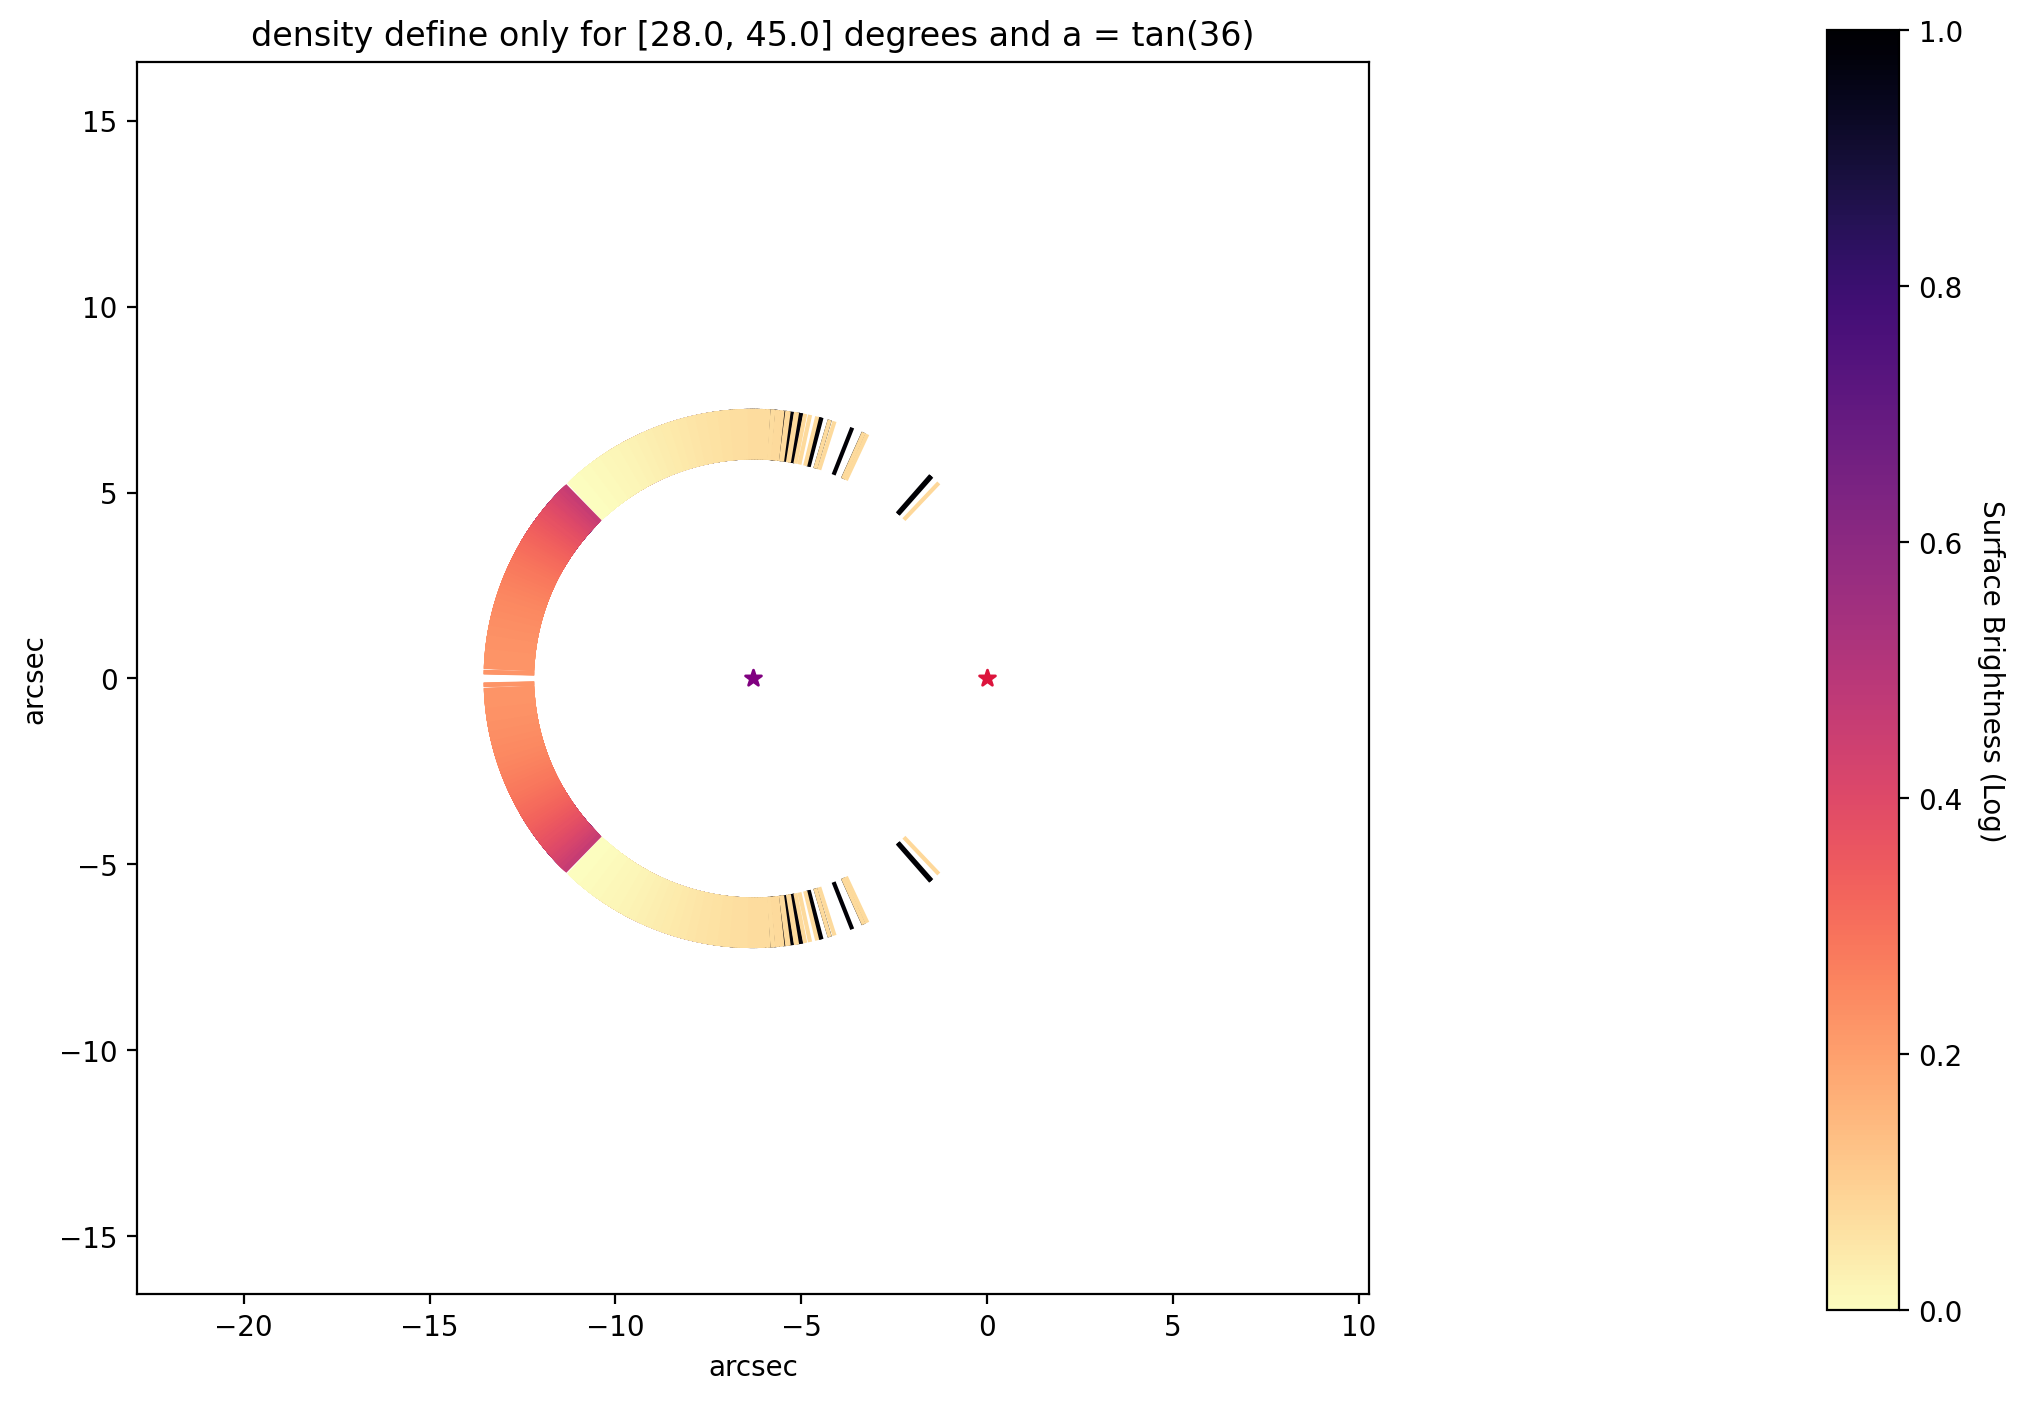

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


surface_300_norm = ( surface.copy() - np.nanmin(surface.copy())  ) / (np.nanmax(surface.copy()) - np.nanmin(surface.copy()))
cmap = matplotlib.colormaps.get_cmap('magma_r')
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))



ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(np.rad2deg(np.arctan(a)))))

r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

for k in range(len(surface)):
  ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(surface[k], cmap(normalize(surface[k])))
ax.scatter(- act, 0, marker = "*", color = "purple")
ax.scatter(0, 0, marker = "*", color = "crimson")



cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
ax.set_box_aspect(1)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

def label_cbrt(x,pos):
    return "{:.1f}".format(x)

cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
# cb.update_ticks()
# # plt.tight_layout()
# # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
# # print(set(legend_dust))
# plt.show()
